## Self Driving Car Nanodegree - Project 3
### Advanced Lane Finding Project
The goals/steps for this project are the following: 
1. Distortion correction using images of chessboards.
2. Perspective transformation to view lane lines from straight above.
3. Processing images to highlight lanelines.
4. Sliding window search to detect lane lines and their curvatures.
5. Drawing the detected lane lines on the original images.

### Step 1 - Distortion correction
Images taken from cameras have distortions, which occur while transforming a 3-D view into a 2-D image. The distortions are properties of camera lenses. For this reason, once the necessary parameters of the distortion are determined, the images can easily be undistorted.  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test image using the cv2.undistort() function and obtained this result:

** 1.1 - Images of chessboards will be loaded and processed to obtain necessary parameters for undistorting image **

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Chessboard process completed!')

Chessboard process completed!


** 1.2 - Now that necessary parameters to undistort images are obtained, a function to undistort images from the camera is defined **

In [2]:
# input image has to be in RGB
def undistort(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return undist

print('undistort() function loaded!')

undistort() function loaded!


** 1.3 - ** Test `undistort()` with a sample image

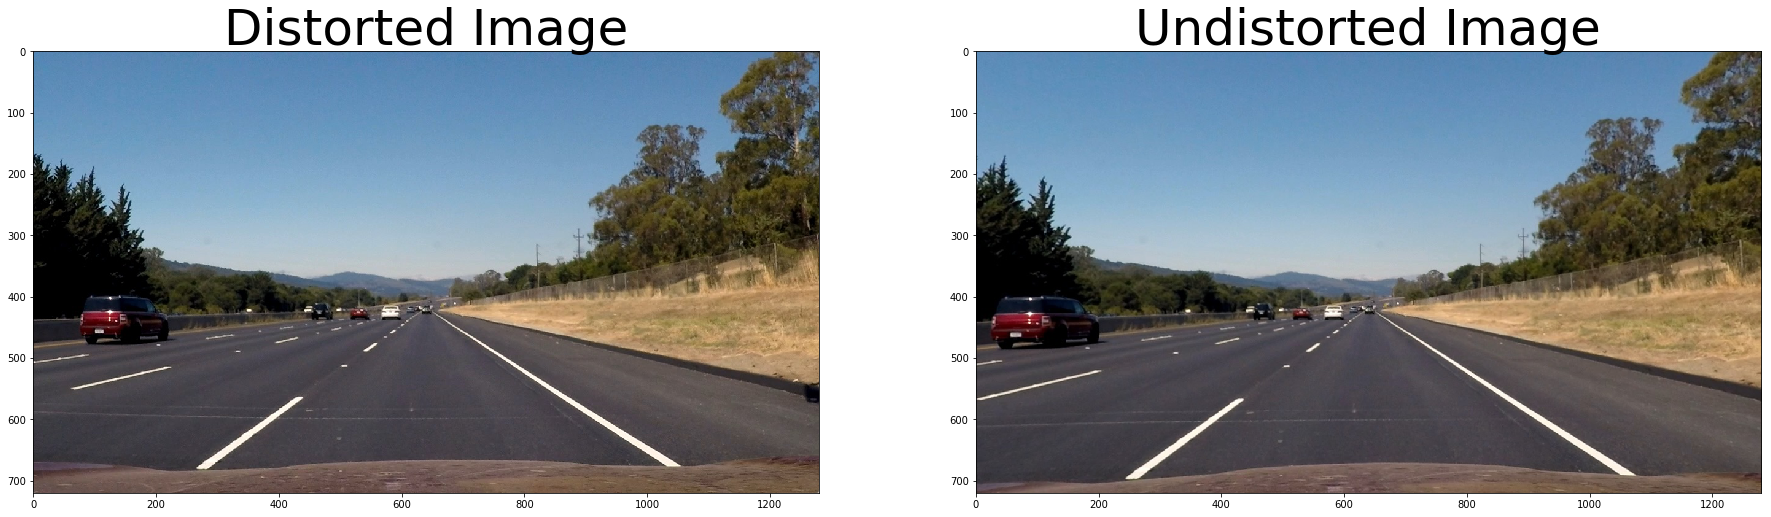

In [3]:
# test undistort()
# load image
test_images_dir = glob.glob('./test_images/*.jpg')
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
# undistort
undist = undistort(test_image)
# plot
fig = plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Distorted Image', fontsize = 50)
plt.subplot(122)
plt.imshow(undist)
plt.title('Undistorted Image', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step 2 - Perspective Transformation
Image captured from a front-facing camera mounted on a vehicle cannot be used for the curvature of the lane lines cannot be measured accurately. Perspective transformation will allow the image to be view from the above straight down, so that the curvatures become more apparent.  
This is conducted in two steps:  
First, a sample image with lane lines will be used to sample four points, that should form a rectangle when viewed from the above.   
Second, the four points will be transformed into a rectangle.

** 2.1 - Obtain four points from an image **  
Using a trial and error method, I found out four points that closely follow the lane lines. In order to find out left and right x coordinates for a given y value, I defined a `x_coord_generator()` function. This takes a single y coordinate, plug it in the two linear functions that follow the lane lines, and return two x coordinates. 

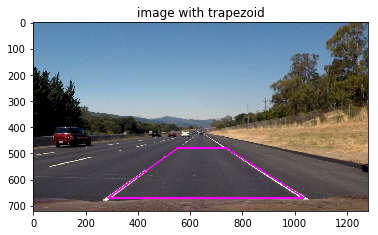

In [4]:
# I will load a clean image of road tofind best-fit a trapezoid
test_images = glob.glob('./test_images/*.jpg')

clean_image = test_images[1]
clean_road_image = cv2.imread(clean_image)
clean_road_image = cv2.cvtColor(clean_road_image, cv2.COLOR_BGR2RGB)
clean_road_image_draw = np.copy(clean_road_image)

# Read from the image approximate coordinates
# x_bottom_left = 215
# x_bottom_right = 1115
# x_top_left = 525
# x_top_right = 771
# y_top = 500
# y_bottom = 720

def x_coord_generator(y_coord):
    # two linear functions are generated with the above points
    x_top_left = 27050/22 -31*y_coord/22
    x_top_right = 69*y_coord/44 - 620/44
    
    return x_top_left, x_top_right

# x coordinates are calculated for two upper and lower y values
y_top = 480
x_top_left, x_top_right = x_coord_generator(y_top)
y_bottom = 670
x_bottom_left, x_bottom_right = x_coord_generator(y_bottom)

coords = np.array([[x_bottom_left,y_bottom],[x_top_left,y_top],
                   [x_top_right,y_top],[x_bottom_right,y_bottom]], np.int32)
coords = coords.reshape((-1,1,2))
clean_road_image_draw = cv2.polylines(clean_road_image_draw, [coords], True, (255, 0, 255), 3)

imgplot = plt.imshow(clean_road_image_draw)
plt.title('image with trapezoid')

#### 2.2 - Function to undergo perspective transformation  
Now that we have figured out four points that closely parallel lane lines, a function to undergo perspective transformation will be constructed. 

In [5]:
# Parameters to do perspective transformation
src = np.float32([[x_bottom_left,y_bottom],[x_top_left,y_top],
                   [x_top_right,y_top],[x_bottom_right,y_bottom]])
offset = 250 
img_size = (clean_road_image.shape[1], clean_road_image.shape[0])
dst = np.float32([[offset, img_size[1]], [offset, offset],
                  [img_size[0]-offset, offset],
                  [img_size[0]-offset, img_size[1]]])
dst_draw = np.array([[offset, img_size[1]-offset], [offset, offset],
                  [img_size[0]-offset, offset],
                  [img_size[0]-offset, img_size[1]-offset]], np.int32)

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def persp_transform(image):
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

print('Perspective Transformation Function loaded!')

Perspective Transformation Function loaded!


#### 2.3 - Test perspective trasnformation with a sample image

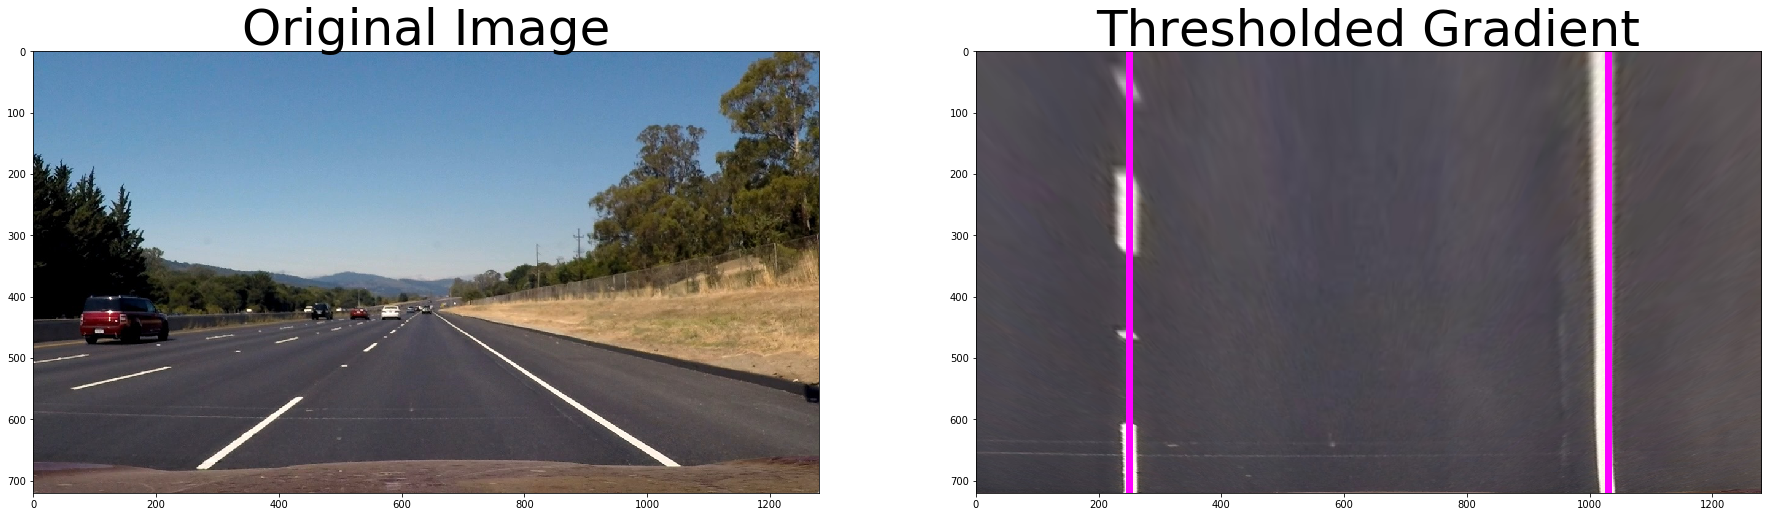

In [6]:
warped = persp_transform(clean_road_image)
dst_draw = dst_draw.reshape((-1,1,2))
cv2.line(warped, (offset, img_size[1]), (offset, 0), (255, 0, 255), 10)
cv2.line(warped, (img_size[0]-offset, img_size[1]), (img_size[0]-offset, 0), (255, 0, 255), 10)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.subplot(121)
plt.imshow(clean_road_image)
plt.title('Original Image', fontsize = 50)
plt.subplot(122)
plt.imshow(warped, cmap='gray')
plt.title('Thresholded Gradient', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3 - Lane Line extraction using Sobel and Color Space
`abs_sobel_thresh()`, `mag_thresh()`, `dir_thresh()`, and color spaces will be used to further process images and highlight lane lines. 

#### 3.1 - Sobel operator

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=6, thresh_max=100):
    # Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel()
    
    if orient == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
        
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply lower and upper thresholds
    thresh_min = thresh_min
    thresh_max = thresh_max
    
    # Create binary output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

print('abs_sobel_thresh loaded!')

abs_sobel_thresh loaded!


Test with a sample image

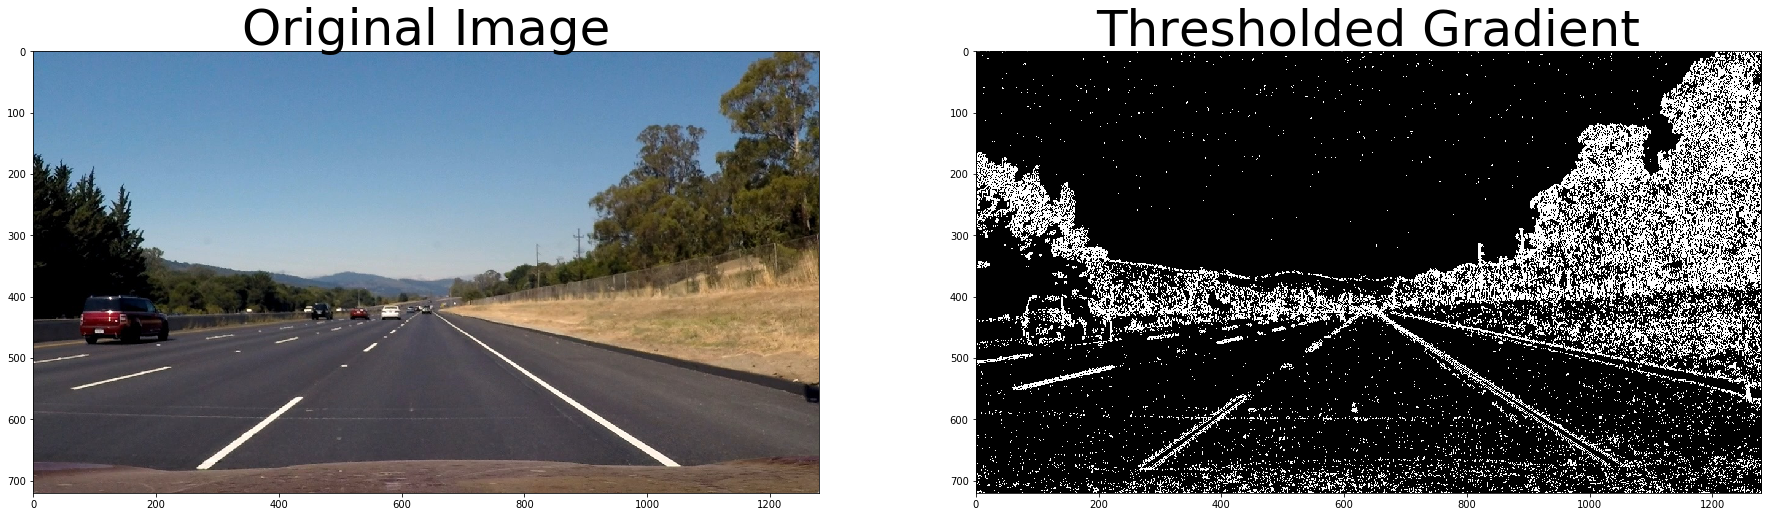

In [8]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

grad_binary = abs_sobel_thresh(test_image, orient='x', thresh_min=6, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image', fontsize = 50)
plt.subplot(122)
plt.imshow(grad_binary, cmap='gray')
plt.title('Thresholded Gradient', fontsize = 50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.2 - Magnitude of Gradient

In [9]:
# magnitude of gradient 
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to Grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelX = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate magnitude
    gradmag = np.sqrt(sobelX**2 + sobelY**2)
    # Scale to 8-bit (0-255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag threshold are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag>=mag_thresh[0]) & (gradmag<=mag_thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

print('mag_thresh loaded!')

mag_thresh loaded!


#### Run Sample image

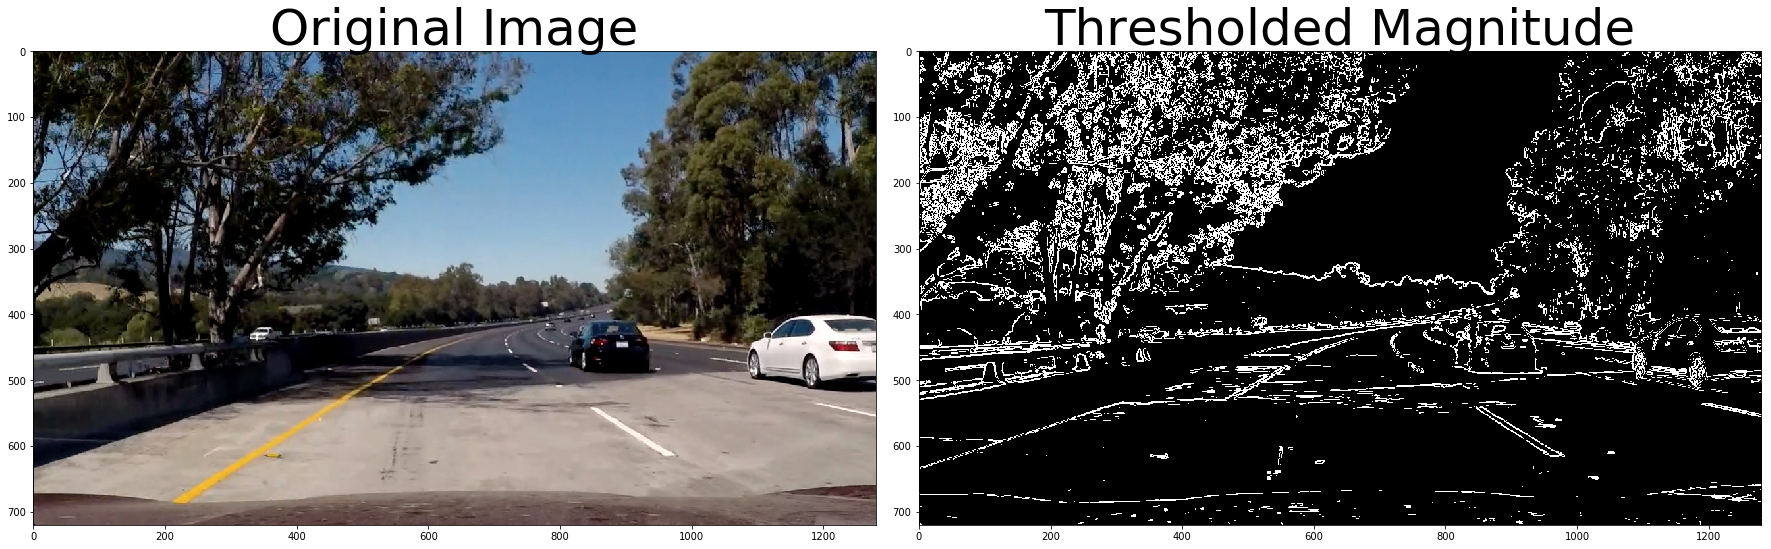

In [10]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

mag_binary = mag_thresh(test_image, sobel_kernel=3, mag_thresh=(30,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.3 - Gradient Direction

In [11]:
# Dirction of gradient 
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take a gradient in x and y separately
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x an dy gradient
    absgraddir = np.arctan2(np.absolute(sobelY), np.absolute(sobelX))
    # Use np.arctan2 to calculate the direction of the gradients
    binary_output = np.zeros_like(absgraddir)
    # Return this mask as binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

** Test with Sample Image **

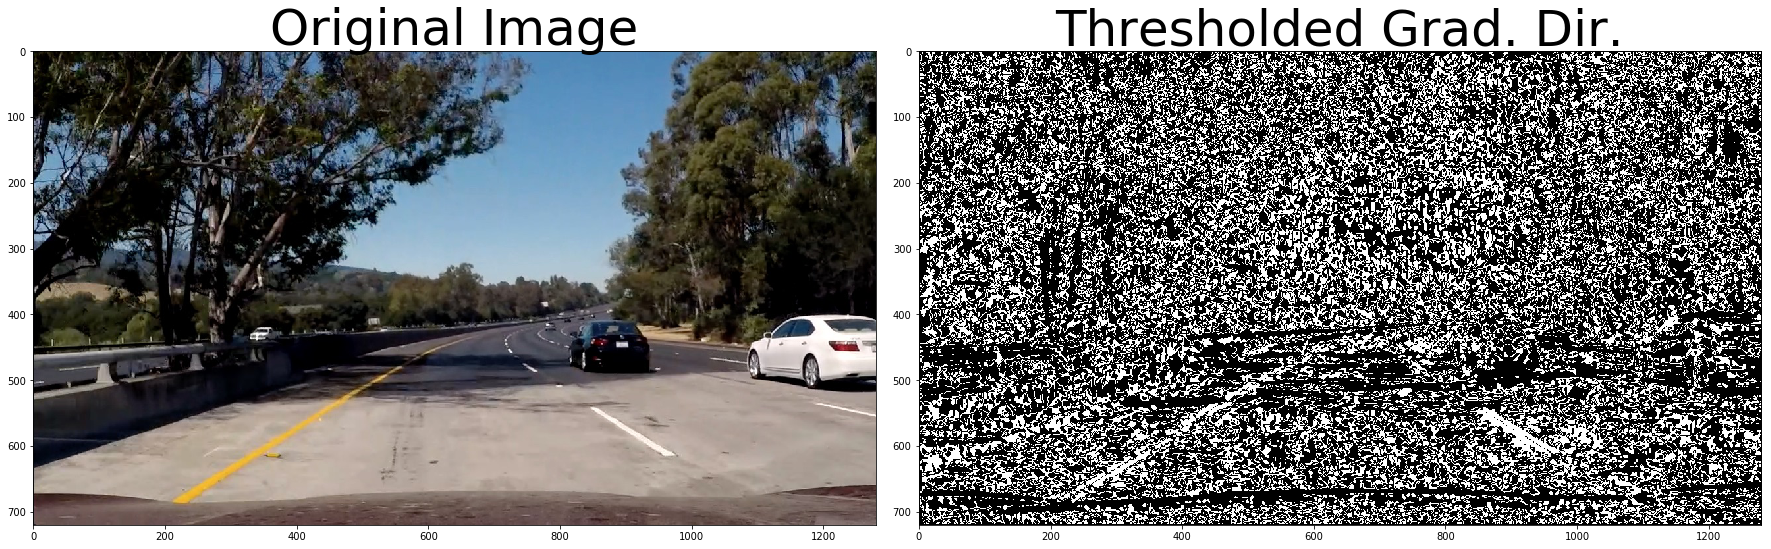

In [12]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

dir_binary = dir_threshold(test_image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 3.4 - HLS Selection

In [13]:
def hls_select(img, thresh=(0,255)):
    # Convert to HLS color space
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s_channel = img_hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    # Return a binary image of threshold result
    return binary_output

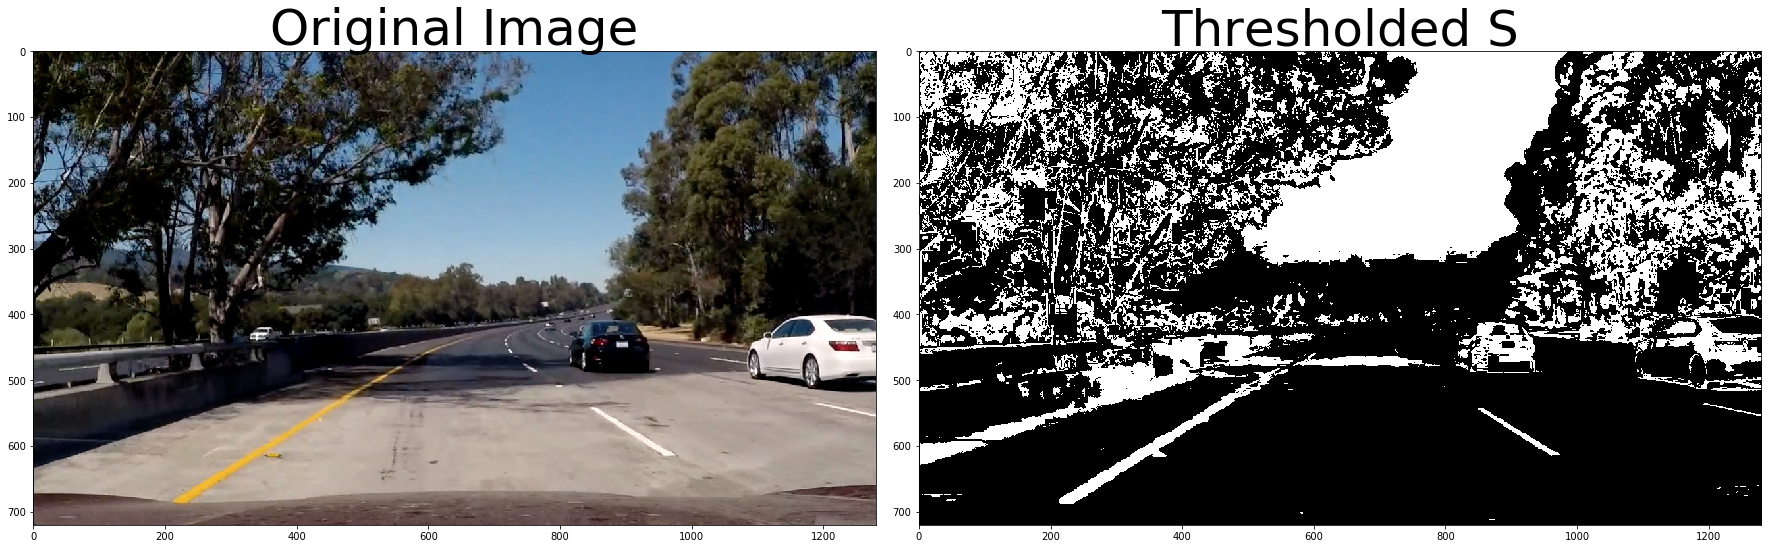

In [14]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

hls_binary = hls_select(test_image, thresh=(85, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3.5 - Final Pipeline using all above methods!

In [15]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel X
    sobelX = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelX = np.absolute(sobelX)
    scaled_sobel = np.uint8(255*abs_sobelX/np.max(abs_sobelX))
    
    # Threshold x gradient 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    
    return combined_binary

** Try out with a sample image **

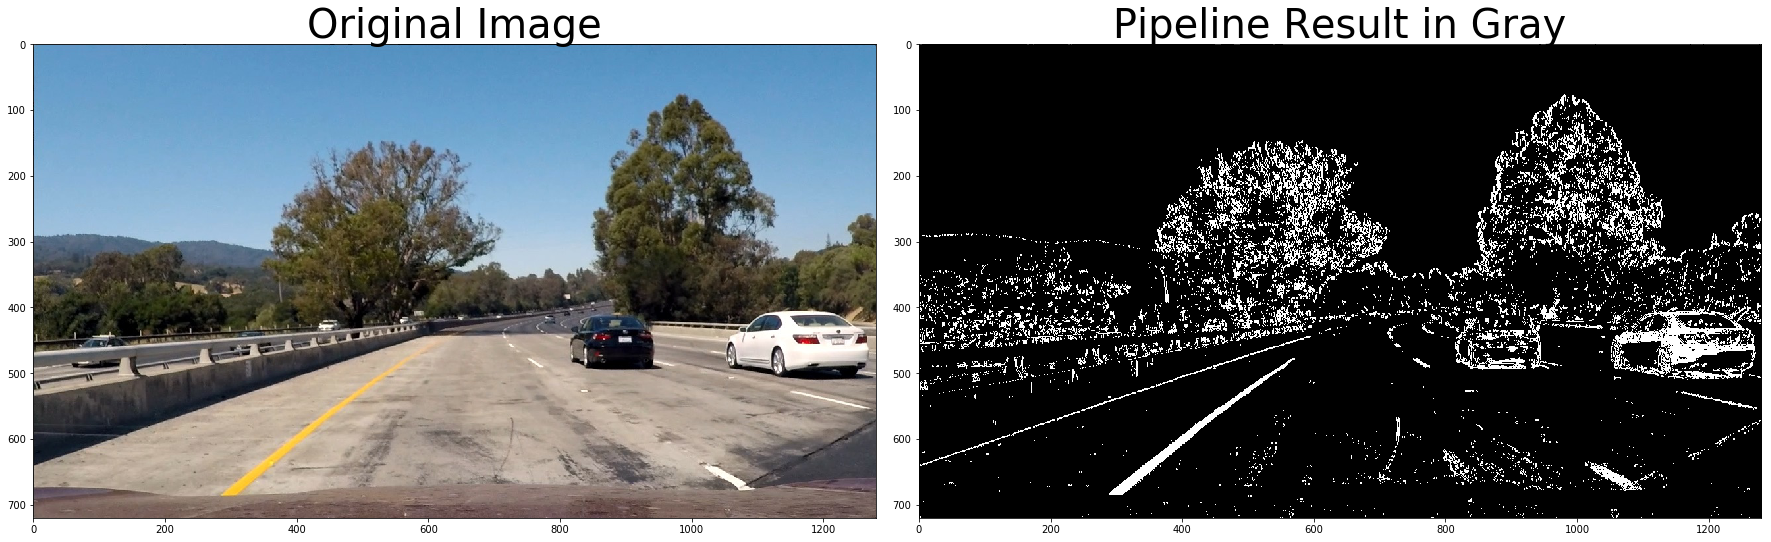

In [16]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

binary = pipeline(test_image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Pipeline Result in Gray', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4 - Sliding Window Search

In [17]:
def hist_sliding_win(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[np.int(image.shape[0]/2):,:], axis=0)
    # Create an output image to draw on & visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    # Current position to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the window +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Plot results
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    ######
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space

    left_fit_cr = np.polyfit(np.multiply(lefty, ym_per_pix), np.multiply(leftx, xm_per_pix), 2)
    right_fit_cr = np.polyfit(np.multiply(righty, ym_per_pix), np.multiply(rightx, xm_per_pix), 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_curverad = np.round(left_curverad, 2)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_curverad = np.round(right_curverad, 2)
    # Now our radius of curvature is in meters
    print('Left Curvature: {} m | Right Curvature: {} m'.format(left_curverad, right_curverad))
    
    return out_img, left_fitx, right_fitx, ploty, (left_curverad + right_curverad)/2

print('function loaded!')

function loaded!


** Test with sample image **

Left Curvature: 685.45 m | Right Curvature: 979.7 m


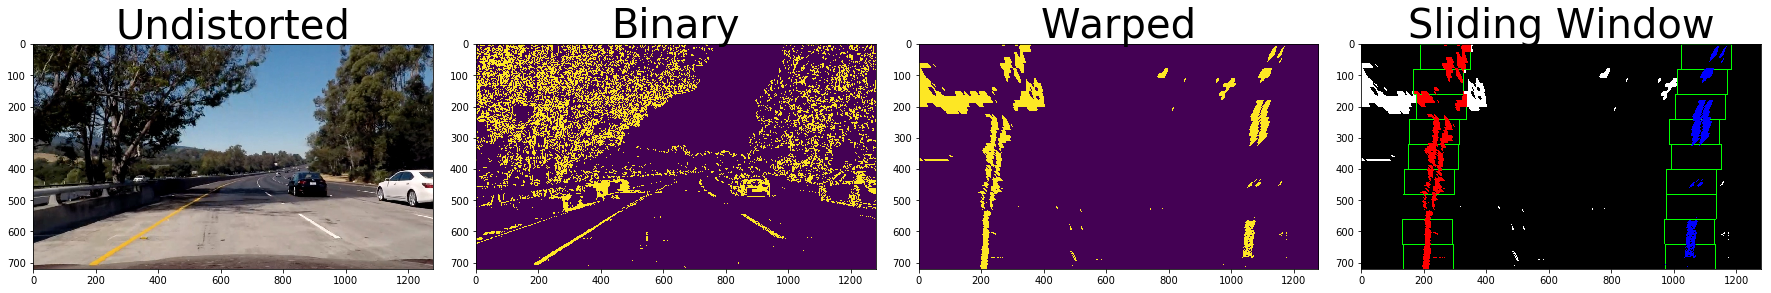

In [18]:
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Plot the results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

# First need to process image before feeding
undist = undistort(test_image)
ax1.imshow(undist)
ax1.set_title('Undistorted', fontsize=40)

binary = pipeline(undist)
ax2.imshow(binary)
ax2.set_title('Binary', fontsize=40)

binary_warped = persp_transform(binary)
ax3.imshow(binary_warped)
ax3.set_title('Warped', fontsize=40)

result, left_fitx, right_fitx, ploty, curv = hist_sliding_win(binary_warped)
ax4.imshow(result)
ax4.set_title('Sliding Window', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Second Sliding Window Method

In [19]:
window_width = 50
window_height = 80
# NOTE: margin 
margin = 70 # How much to slide left or right for search 

# level - row?
def window_mask(width, height, draw_on_image, center, level):
    output = np.zeros_like(draw_on_image)
    img_width = draw_on_image.shape[0]
    img_height = draw_on_image.shape[1]
    output[int(img_width-(level+1)*height):int(img_width-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_height)] = 1
    return output

def find_window_centroids(warped, window_width=50, window_height=80, margin=50):
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

# level - row?
def window_mask(width, height, draw_on_image, center, level):
    output = np.zeros_like(draw_on_image)
    output[int(draw_on_image.shape[0]-(level+1)*height):int(draw_on_image.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),draw_on_image.shape[1])] = 1
    return output


In [20]:
def sliding_window2(warped):
    window_centroids = find_window_centroids(warped, window_width=50, 
                                             window_height=80, margin=70)
    if len(window_centroids) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            # l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)

            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        # If no window centers found, just display orginal road image
        y_val = [int(warped.shape[0]-(level+1)*window_height) for level in range(9)]
        y_val = y_val[::-1]
        x_left = [int(window_centroids[i][0]) for i in range(9)]
        x_right = [int(window_centroids[i][1]) for i in range(9)]
        left_fit = np.polyfit(y_val, x_left, 2)
        right_fit = np.polyfit(y_val, x_right, 2)
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    
#     Display the final results
#     plt.imshow(output)
#     plt.plot(left_fitx, ploty[::-1], color='yellow')
#     plt.plot(right_fitx, ploty[::-1], color='red')
#     plt.title('window fitting results')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.show()

    # PRINT OUT IN METERS
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space

    left_fit_cr = np.polyfit(np.multiply(y_val, ym_per_pix), np.multiply(x_left, xm_per_pix), 2)
    right_fit_cr = np.polyfit(np.multiply(y_val, ym_per_pix), np.multiply(x_right, xm_per_pix), 2)
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    left_curverad = np.round(left_curverad, 2)
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    right_curverad = np.round(right_curverad, 2)
    # Now our radius of curvature is in meters
    print('Left Curvature: {} m | Right Curvature: {} m'.format(left_curverad, right_curverad))
    
    return left_fitx, right_fitx, ploty[::-1], (left_curverad+right_curverad)/2

In [21]:
# Drawing back 
def draw_to_original(warped, undist, image, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
    return result

### Generate a class to do sanity check of the car iamge

In [22]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
# How?
# for n numbers. 
# if less than n, 
# sanity check only with radius_of_curvature, others. 
def check(new_radius_of_curvature, line_inst):
    thresh = 0.5
    if (new_radius_of_curvature < line_inst.radius_of_curvature*(1+thresh) and 
        new_radius_of_curvature > line_inst.radius_of_curvature*(1-thresh)):
        return True
    else:
        return False
    
def sanity_check_n_draw(binary_warped, undist, line_instance, image, curvature, left_fitx, right_fitx, ploty, num_recent=12):
    # For the first n images, accumulate data
    
    if (len(line_instance.recent_xfitted) < num_recent):
        line_instance.recent_xfitted.extend([left_fitx, right_fitx])
        line_instance.radius_of_curvature = curvature
        result = draw_to_original(binary_warped, undist, image, left_fitx, right_fitx, ploty)
        line_instance.detected = True
    else:
        if check(curvature, line_instance):
            line_instance.recent_xfitted.pop(0)
            line_instance.recent_xfitted.pop(0)

            line_instance.recent_xfitted.extend([left_fitx, right_fitx])
            
            # Finding the average best fit of the recent x
            x_fitted = line_instance.recent_xfitted
            x_left = [line_instance.recent_xfitted[i] for i in range(0, len(line_instance.recent_xfitted), 2)]
            x_right = [line_instance.recent_xfitted[i] for i in range(0, len(line_instance.recent_xfitted), 2)]
            left_mat = np.zeros_like(x_left[0])
            right_mat = np.zeros_like(x_right[0])
            
            for i in range(len(x_left)):
                left_mat = np.add(left_mat, x_left[i])
                right_mat = np.add(right_mat, x_right[i])
                            
            left_avg_mat = np.divide(left_mat, len(x_left))
            right_avg_mat = np.divide(right_mat, len(x_right))
            
            line_instance.bestx = [left_avg_mat, right_avg_mat]
            line_instance.radius_of_curvature = curvature
            result = draw_to_original(binary_warped, undist, image, left_avg_mat, right_avg_mat, ploty)
            line_instance.detected = True
            
        else:
                        
            # Finding the average best fit of the recent x
            x_fitted = line_instance.recent_xfitted
            x_left = [line_instance.recent_xfitted[i] for i in range(0, len(line_instance.recent_xfitted), 2)]
            x_right = [line_instance.recent_xfitted[i] for i in range(1, len(line_instance.recent_xfitted), 2)]
            left_mat = np.zeros_like(x_left[0])
            right_mat = np.zeros_like(x_right[0])
            
            for i in range(0,len(x_left)):
                left_mat = np.add(left_mat, x_left[i])
                right_mat = np.add(right_mat, x_right[i])
                
            left_avg_mat = np.divide(left_mat, len(x_left))
            right_avg_mat = np.divide(right_mat, len(x_right))
            
            line_instance.bestx = [left_avg_mat, right_avg_mat]
            # hi
            result = draw_to_original(binary_warped, undist, image, left_avg_mat, right_avg_mat, ploty)
            line_instance.detected = False

    return result

### Complete pipeline from raw image to image with mask showing detected lane lines

In [25]:
default_test = Line()
def complete_pipeline(image, line_instance=default_test):    
    # 1 - Undistort image 
    undist = undistort(image)
    # 2 - Binary
    binary = pipeline(undist)
    # 3 - Perspective Transformation
    binary_warped = persp_transform(binary)
    # 4 - Use sliding window
    #  left, right, ploty = sliding_window2(binary_warped)

    left, right, ploty, curvature = sliding_window2(binary_warped)

    # 5 - Draw back to original image
    # if: lane line looks good, plot with the new data
    # else: plot with the previous data
    # ** Since the images are nearly identical frame by frame, taking average of 
    # the most recent 5 will be fine. 
    result = sanity_check_n_draw(binary_warped, undist, line_instance, image, curvature, left, right, ploty)
    return result

In [26]:
# Test with sample image
rand_idx = np.random.randint(0, len(test_images_dir)-1)
test_image = cv2.imread(test_images_dir[rand_idx])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
check_test = Line()
complete_pipeline(test_image, check_test)

Left Curvature: 827.05 m | Right Curvature: 302.51 m


array([[[ 96, 145, 188],
        [ 95, 144, 187],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 94, 143, 186],
        ..., 
        [ 78, 130, 180],
        [ 78, 130, 180],
        [ 78, 130, 180]],

       [[ 95, 144, 187],
        [ 94, 143, 186],
        [ 93, 142, 185],
        ..., 
        [ 78, 130, 179],
        [ 78, 130, 179],
        [ 78, 130, 178]],

       ..., 
       [[ 97,  83,  96],
        [ 98,  84,  97],
        [ 98,  84,  98],
        ..., 
        [122,  98,  88],
        [121,  97,  87],
        [119,  95,  85]],

       [[ 97,  84,  96],
        [ 98,  85,  97],
        [ 99,  86,  98],
        ..., 
        [121,  97,  87],
        [122,  98,  88],
        [120,  96,  86]],

       [[100,  87,  97],
        [100,  87,  97],
        [101,  88,  98],
        ..., 
        [118,  95,  85],
        [120,  96,  86],
        [119,  95,

## Let's apply the pipeline to a video clip

In [27]:
# # Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
output = './test_video_output/TestOutput.mp4'
clip2 = VideoFileClip('./project_video.mp4')
test_clip = clip2.fl_image(complete_pipeline)
%time test_clip.write_videofile(output, audio=False)

Left Curvature: 739.22 m | Right Curvature: 1384.3 m
[MoviePy] >>>> Building video ./test_video_output/TestOutput.mp4
[MoviePy] Writing video ./test_video_output/TestOutput.mp4


  0%|          | 1/1261 [00:00<03:16,  6.40it/s]

Left Curvature: 739.22 m | Right Curvature: 1384.3 m


  0%|          | 2/1261 [00:00<03:10,  6.62it/s]

Left Curvature: 760.54 m | Right Curvature: 759.98 m


  0%|          | 3/1261 [00:00<03:06,  6.75it/s]

Left Curvature: 842.71 m | Right Curvature: 10683.26 m


  0%|          | 4/1261 [00:00<03:03,  6.86it/s]

Left Curvature: 761.2 m | Right Curvature: 482.85 m


  0%|          | 5/1261 [00:00<03:02,  6.87it/s]

Left Curvature: 711.35 m | Right Curvature: 695.75 m


  0%|          | 6/1261 [00:00<03:02,  6.89it/s]

Left Curvature: 745.56 m | Right Curvature: 598.16 m


  1%|          | 7/1261 [00:01<03:01,  6.90it/s]

Left Curvature: 673.22 m | Right Curvature: 373.66 m


  1%|          | 8/1261 [00:01<03:01,  6.92it/s]

Left Curvature: 769.18 m | Right Curvature: 5065.8 m


  1%|          | 9/1261 [00:01<02:58,  7.00it/s]

Left Curvature: 812.8 m | Right Curvature: 855.75 m


  1%|          | 10/1261 [00:01<02:58,  6.99it/s]

Left Curvature: 765.82 m | Right Curvature: 940.11 m


  1%|          | 11/1261 [00:01<03:01,  6.87it/s]

Left Curvature: 673.0 m | Right Curvature: 1679.98 m


  1%|          | 12/1261 [00:01<03:07,  6.66it/s]

Left Curvature: 732.58 m | Right Curvature: 1372.66 m
Left Curvature: 673.6 m | Right Curvature: 794.87 m


  1%|          | 14/1261 [00:02<03:25,  6.06it/s]

Left Curvature: 726.67 m | Right Curvature: 1954.02 m


  1%|          | 15/1261 [00:02<03:30,  5.92it/s]

Left Curvature: 932.6 m | Right Curvature: 19071.88 m


  1%|▏         | 16/1261 [00:02<03:33,  5.83it/s]

Left Curvature: 907.47 m | Right Curvature: 609.38 m


  1%|▏         | 17/1261 [00:02<03:36,  5.76it/s]

Left Curvature: 815.81 m | Right Curvature: 583.73 m


  1%|▏         | 18/1261 [00:02<03:37,  5.71it/s]

Left Curvature: 989.35 m | Right Curvature: 1067.89 m


  2%|▏         | 19/1261 [00:03<03:40,  5.64it/s]

Left Curvature: 1108.57 m | Right Curvature: 481.47 m


  2%|▏         | 20/1261 [00:03<03:36,  5.74it/s]

Left Curvature: 940.75 m | Right Curvature: 587.26 m


  2%|▏         | 21/1261 [00:03<03:33,  5.82it/s]

Left Curvature: 1176.88 m | Right Curvature: 1495.63 m


  2%|▏         | 22/1261 [00:03<03:31,  5.85it/s]

Left Curvature: 1080.43 m | Right Curvature: 809.6 m


  2%|▏         | 23/1261 [00:03<03:31,  5.85it/s]

Left Curvature: 1176.84 m | Right Curvature: 815.86 m


  2%|▏         | 24/1261 [00:03<03:34,  5.76it/s]

Left Curvature: 918.58 m | Right Curvature: 3411.89 m
Left Curvature: 961.9 m | Right Curvature: 777.48 m


  2%|▏         | 25/1261 [00:04<03:41,  5.57it/s]

Left Curvature: 1114.68 m | Right Curvature: 1569.94 m


  2%|▏         | 27/1261 [00:04<03:40,  5.61it/s]

Left Curvature: 987.13 m | Right Curvature: 1089.01 m


  2%|▏         | 28/1261 [00:04<03:33,  5.76it/s]

Left Curvature: 860.08 m | Right Curvature: 664.4 m
Left Curvature: 947.67 m | Right Curvature: 4837.33 m


  2%|▏         | 31/1261 [00:05<03:46,  5.43it/s]

Left Curvature: 956.93 m | Right Curvature: 1846.02 m
Left Curvature: 721.45 m | Right Curvature: 956.81 m


  3%|▎         | 33/1261 [00:05<03:40,  5.56it/s]

Left Curvature: 704.69 m | Right Curvature: 399.57 m
Left Curvature: 764.87 m | Right Curvature: 2439.07 m


  3%|▎         | 34/1261 [00:05<03:47,  5.39it/s]

Left Curvature: 731.67 m | Right Curvature: 888.55 m
Left Curvature: 738.28 m | Right Curvature: 978.64 m


  3%|▎         | 36/1261 [00:06<03:51,  5.30it/s]

Left Curvature: 661.84 m | Right Curvature: 18695.8 m


  3%|▎         | 37/1261 [00:06<03:57,  5.16it/s]

Left Curvature: 709.95 m | Right Curvature: 314.46 m
Left Curvature: 670.47 m | Right Curvature: 518.58 m

  3%|▎         | 39/1261 [00:06<03:58,  5.12it/s]


Left Curvature: 602.78 m | Right Curvature: 778.37 m
Left Curvature: 621.25 m | Right Curvature: 2117.09 m

  3%|▎         | 41/1261 [00:07<04:02,  5.03it/s]


Left Curvature: 554.14 m | Right Curvature: 462.0 m


  3%|▎         | 42/1261 [00:07<04:10,  4.87it/s]

Left Curvature: 586.69 m | Right Curvature: 407.53 m


  3%|▎         | 43/1261 [00:07<04:16,  4.76it/s]

Left Curvature: 581.15 m | Right Curvature: 1248.18 m


  3%|▎         | 44/1261 [00:07<04:13,  4.80it/s]

Left Curvature: 564.47 m | Right Curvature: 597.01 m
Left Curvature: 578.52 m | Right Curvature: 427.05 m


  4%|▎         | 47/1261 [00:08<03:49,  5.29it/s]

Left Curvature: 550.93 m | Right Curvature: 1291.99 m
Left Curvature: 622.66 m | Right Curvature: 741.92 m


  4%|▍         | 49/1261 [00:08<03:39,  5.53it/s]

Left Curvature: 567.93 m | Right Curvature: 587.34 m
Left Curvature: 583.22 m | Right Curvature: 1272.02 m


  4%|▍         | 50/1261 [00:08<03:43,  5.42it/s]

Left Curvature: 647.2 m | Right Curvature: 992.81 m
Left Curvature: 678.65 m | Right Curvature: 933.92 m


  4%|▍         | 53/1261 [00:09<03:39,  5.49it/s]

Left Curvature: 666.53 m | Right Curvature: 676.31 m
Left Curvature: 773.45 m | Right Curvature: 13702.21 m


  4%|▍         | 55/1261 [00:09<03:37,  5.54it/s]

Left Curvature: 783.97 m | Right Curvature: 445.85 m
Left Curvature: 794.15 m | Right Curvature: 383.13 m


  5%|▍         | 57/1261 [00:10<03:33,  5.64it/s]

Left Curvature: 914.57 m | Right Curvature: 766.85 m
Left Curvature: 990.64 m | Right Curvature: 465.36 m


  5%|▍         | 59/1261 [00:10<03:43,  5.38it/s]

Left Curvature: 934.63 m | Right Curvature: 580.1 m
Left Curvature: 949.05 m | Right Curvature: 735.67 m


  5%|▍         | 61/1261 [00:10<03:30,  5.70it/s]

Left Curvature: 969.64 m | Right Curvature: 762.72 m
Left Curvature: 894.14 m | Right Curvature: 339.68 m


  5%|▍         | 63/1261 [00:11<03:29,  5.73it/s]

Left Curvature: 814.91 m | Right Curvature: 700.22 m
Left Curvature: 786.66 m | Right Curvature: 1890.99 m


  5%|▌         | 65/1261 [00:11<03:23,  5.88it/s]

Left Curvature: 818.92 m | Right Curvature: 760.95 m
Left Curvature: 689.41 m | Right Curvature: 54048.98 m


  5%|▌         | 67/1261 [00:11<03:21,  5.92it/s]

Left Curvature: 683.55 m | Right Curvature: 709.13 m
Left Curvature: 689.34 m | Right Curvature: 867.64 m


  5%|▌         | 69/1261 [00:12<03:26,  5.76it/s]

Left Curvature: 700.26 m | Right Curvature: 1132.69 m
Left Curvature: 747.96 m | Right Curvature: 567.66 m


  6%|▌         | 70/1261 [00:12<03:28,  5.73it/s]

Left Curvature: 752.58 m | Right Curvature: 28605.82 m
Left Curvature: 851.04 m | Right Curvature: 1298.67 m


  6%|▌         | 73/1261 [00:12<03:39,  5.41it/s]

Left Curvature: 911.53 m | Right Curvature: 1991.44 m
Left Curvature: 814.8 m | Right Curvature: 15189.04 m


  6%|▌         | 74/1261 [00:13<03:43,  5.31it/s]

Left Curvature: 1007.49 m | Right Curvature: 864.31 m
Left Curvature: 1094.68 m | Right Curvature: 355.58 m


  6%|▌         | 77/1261 [00:13<03:34,  5.52it/s]

Left Curvature: 1263.48 m | Right Curvature: 1698.53 m
Left Curvature: 1307.59 m | Right Curvature: 876.01 m


  6%|▌         | 78/1261 [00:13<03:32,  5.57it/s]

Left Curvature: 1375.87 m | Right Curvature: 1812.34 m
Left Curvature: 1676.7 m | Right Curvature: 44181.26 m


  6%|▋         | 81/1261 [00:14<03:33,  5.54it/s]

Left Curvature: 1715.03 m | Right Curvature: 411.5 m
Left Curvature: 1653.69 m | Right Curvature: 1306.8 m


  7%|▋         | 82/1261 [00:14<03:34,  5.50it/s]

Left Curvature: 1599.3 m | Right Curvature: 457.48 m
Left Curvature: 1521.71 m | Right Curvature: 497.96 m


  7%|▋         | 85/1261 [00:15<03:34,  5.47it/s]

Left Curvature: 1541.01 m | Right Curvature: 2507.1 m
Left Curvature: 1419.57 m | Right Curvature: 878.41 m


  7%|▋         | 87/1261 [00:15<03:28,  5.64it/s]

Left Curvature: 1291.49 m | Right Curvature: 1042.54 m
Left Curvature: 1254.72 m | Right Curvature: 1437.2 m


  7%|▋         | 89/1261 [00:15<03:29,  5.58it/s]

Left Curvature: 1251.39 m | Right Curvature: 741.64 m
Left Curvature: 984.45 m | Right Curvature: 3002.26 m


  7%|▋         | 90/1261 [00:16<03:35,  5.44it/s]

Left Curvature: 1002.65 m | Right Curvature: 97253.95 m
Left Curvature: 889.11 m | Right Curvature: 686.62 m


  7%|▋         | 93/1261 [00:16<03:32,  5.50it/s]

Left Curvature: 942.49 m | Right Curvature: 572.7 m
Left Curvature: 827.35 m | Right Curvature: 2345.38 m


  7%|▋         | 94/1261 [00:16<03:30,  5.55it/s]

Left Curvature: 756.12 m | Right Curvature: 532.78 m
Left Curvature: 759.15 m | Right Curvature: 566.44 m


  8%|▊         | 97/1261 [00:17<03:25,  5.65it/s]

Left Curvature: 758.57 m | Right Curvature: 1535.06 m
Left Curvature: 819.81 m | Right Curvature: 782.85 m


  8%|▊         | 99/1261 [00:17<03:21,  5.77it/s]

Left Curvature: 911.92 m | Right Curvature: 727.05 m
Left Curvature: 963.29 m | Right Curvature: 1063.8 m


  8%|▊         | 101/1261 [00:17<03:26,  5.62it/s]

Left Curvature: 1005.0 m | Right Curvature: 373.95 m
Left Curvature: 1005.01 m | Right Curvature: 1630.05 m


  8%|▊         | 103/1261 [00:18<03:27,  5.57it/s]

Left Curvature: 1022.91 m | Right Curvature: 780.74 m
Left Curvature: 935.43 m | Right Curvature: 5229.05 m


  8%|▊         | 104/1261 [00:18<03:29,  5.52it/s]

Left Curvature: 851.33 m | Right Curvature: 121486.75 m
Left Curvature: 995.76 m | Right Curvature: 423.12 m


  8%|▊         | 106/1261 [00:18<03:34,  5.39it/s]

Left Curvature: 1016.53 m | Right Curvature: 960.13 m
Left Curvature: 879.82 m | Right Curvature: 513.3 m


  9%|▊         | 109/1261 [00:19<03:26,  5.57it/s]

Left Curvature: 920.58 m | Right Curvature: 661.9 m
Left Curvature: 887.94 m | Right Curvature: 6076.93 m


  9%|▊         | 110/1261 [00:19<03:28,  5.53it/s]

Left Curvature: 1053.99 m | Right Curvature: 903.49 m
Left Curvature: 924.08 m | Right Curvature: 10562.74 m


  9%|▉         | 113/1261 [00:20<03:22,  5.66it/s]

Left Curvature: 902.73 m | Right Curvature: 2619.77 m
Left Curvature: 908.57 m | Right Curvature: 832.93 m


  9%|▉         | 115/1261 [00:20<03:20,  5.71it/s]

Left Curvature: 918.87 m | Right Curvature: 1488.09 m
Left Curvature: 795.85 m | Right Curvature: 792.74 m


  9%|▉         | 116/1261 [00:20<03:25,  5.56it/s]

Left Curvature: 701.0 m | Right Curvature: 12154.97 m
Left Curvature: 693.51 m | Right Curvature: 486.14 m


  9%|▉         | 119/1261 [00:21<03:26,  5.52it/s]

Left Curvature: 698.5 m | Right Curvature: 489.82 m
Left Curvature: 634.88 m | Right Curvature: 951.51 m


 10%|▉         | 120/1261 [00:21<03:24,  5.58it/s]

Left Curvature: 572.13 m | Right Curvature: 422.39 m
Left Curvature: 595.84 m | Right Curvature: 1348.66 m


 10%|▉         | 122/1261 [00:21<03:46,  5.04it/s]

Left Curvature: 575.19 m | Right Curvature: 636.95 m


 10%|▉         | 123/1261 [00:22<04:01,  4.72it/s]

Left Curvature: 552.19 m | Right Curvature: 707.37 m
Left Curvature: 620.17 m | Right Curvature: 489.22 m


 10%|▉         | 126/1261 [00:22<03:27,  5.47it/s]

Left Curvature: 662.23 m | Right Curvature: 431.37 m
Left Curvature: 757.84 m | Right Curvature: 1575.47 m


 10%|█         | 127/1261 [00:22<03:25,  5.52it/s]

Left Curvature: 745.65 m | Right Curvature: 1344.99 m


 10%|█         | 128/1261 [00:23<03:34,  5.28it/s]

Left Curvature: 730.62 m | Right Curvature: 595.82 m
Left Curvature: 660.53 m | Right Curvature: 464.69 m


 10%|█         | 130/1261 [00:23<03:29,  5.40it/s]

Left Curvature: 562.83 m | Right Curvature: 466.42 m
Left Curvature: 617.12 m | Right Curvature: 1292.38 m


 11%|█         | 133/1261 [00:23<03:24,  5.52it/s]

Left Curvature: 617.18 m | Right Curvature: 425.75 m
Left Curvature: 675.6 m | Right Curvature: 1862.01 m


 11%|█         | 135/1261 [00:24<03:15,  5.76it/s]

Left Curvature: 670.09 m | Right Curvature: 843.62 m
Left Curvature: 675.17 m | Right Curvature: 802.98 m


 11%|█         | 137/1261 [00:24<03:12,  5.84it/s]

Left Curvature: 756.75 m | Right Curvature: 4610.39 m
Left Curvature: 882.73 m | Right Curvature: 870.76 m


 11%|█         | 139/1261 [00:24<03:11,  5.86it/s]

Left Curvature: 926.28 m | Right Curvature: 360.67 m
Left Curvature: 758.04 m | Right Curvature: 1399.03 m


 11%|█         | 141/1261 [00:25<03:11,  5.85it/s]

Left Curvature: 875.57 m | Right Curvature: 1805.36 m
Left Curvature: 793.67 m | Right Curvature: 8923.85 m


 11%|█▏        | 143/1261 [00:25<03:08,  5.94it/s]

Left Curvature: 864.57 m | Right Curvature: 13317.89 m
Left Curvature: 804.01 m | Right Curvature: 501.05 m


 11%|█▏        | 145/1261 [00:25<03:08,  5.92it/s]

Left Curvature: 830.68 m | Right Curvature: 1136.17 m
Left Curvature: 956.98 m | Right Curvature: 508.94 m


 12%|█▏        | 146/1261 [00:26<03:14,  5.72it/s]

Left Curvature: 922.55 m | Right Curvature: 7904.81 m
Left Curvature: 965.48 m | Right Curvature: 1386.83 m


 12%|█▏        | 148/1261 [00:26<03:22,  5.49it/s]

Left Curvature: 1040.6 m | Right Curvature: 1281.55 m
Left Curvature: 1143.09 m | Right Curvature: 423.31 m


 12%|█▏        | 151/1261 [00:27<03:19,  5.56it/s]

Left Curvature: 972.11 m | Right Curvature: 419.38 m
Left Curvature: 1158.06 m | Right Curvature: 2157.36 m


 12%|█▏        | 152/1261 [00:27<03:28,  5.32it/s]

Left Curvature: 1120.74 m | Right Curvature: 1750.0 m
Left Curvature: 1174.73 m | Right Curvature: 88407.29 m


 12%|█▏        | 155/1261 [00:27<03:22,  5.47it/s]

Left Curvature: 971.05 m | Right Curvature: 14508.93 m
Left Curvature: 878.35 m | Right Curvature: 475.87 m


 12%|█▏        | 157/1261 [00:28<03:18,  5.56it/s]

Left Curvature: 836.16 m | Right Curvature: 1978.57 m
Left Curvature: 826.31 m | Right Curvature: 626.87 m


 13%|█▎        | 159/1261 [00:28<03:17,  5.58it/s]

Left Curvature: 761.77 m | Right Curvature: 2290.04 m
Left Curvature: 759.45 m | Right Curvature: 1115.76 m


 13%|█▎        | 160/1261 [00:28<03:23,  5.40it/s]

Left Curvature: 782.56 m | Right Curvature: 1341.75 m
Left Curvature: 745.01 m | Right Curvature: 36003.0 m


 13%|█▎        | 162/1261 [00:29<03:20,  5.49it/s]

Left Curvature: 769.19 m | Right Curvature: 1294.34 m
Left Curvature: 823.0 m | Right Curvature: 789.21 m


 13%|█▎        | 165/1261 [00:29<03:14,  5.64it/s]

Left Curvature: 770.41 m | Right Curvature: 4139.34 m
Left Curvature: 755.46 m | Right Curvature: 937.42 m


 13%|█▎        | 167/1261 [00:29<03:10,  5.73it/s]

Left Curvature: 708.39 m | Right Curvature: 828.77 m
Left Curvature: 698.21 m | Right Curvature: 796.88 m


 13%|█▎        | 169/1261 [00:30<03:13,  5.65it/s]

Left Curvature: 695.85 m | Right Curvature: 7719.42 m
Left Curvature: 717.91 m | Right Curvature: 1388.51 m


 14%|█▎        | 171/1261 [00:30<03:12,  5.67it/s]

Left Curvature: 808.2 m | Right Curvature: 666.73 m
Left Curvature: 835.86 m | Right Curvature: 3922.15 m


 14%|█▎        | 173/1261 [00:31<03:10,  5.70it/s]

Left Curvature: 863.22 m | Right Curvature: 721.0 m
Left Curvature: 881.07 m | Right Curvature: 585.08 m


 14%|█▍        | 174/1261 [00:31<03:13,  5.61it/s]

Left Curvature: 1020.21 m | Right Curvature: 314.51 m
Left Curvature: 1023.36 m | Right Curvature: 523.11 m


 14%|█▍        | 176/1261 [00:31<03:21,  5.39it/s]

Left Curvature: 1025.51 m | Right Curvature: 822.14 m
Left Curvature: 959.84 m | Right Curvature: 569.25 m


 14%|█▍        | 179/1261 [00:32<03:19,  5.41it/s]

Left Curvature: 949.53 m | Right Curvature: 1198.53 m
Left Curvature: 986.96 m | Right Curvature: 374.07 m


 14%|█▍        | 180/1261 [00:32<03:15,  5.53it/s]

Left Curvature: 812.67 m | Right Curvature: 311.42 m
Left Curvature: 764.82 m | Right Curvature: 564.01 m


 15%|█▍        | 183/1261 [00:32<03:17,  5.46it/s]

Left Curvature: 722.91 m | Right Curvature: 324.85 m
Left Curvature: 653.72 m | Right Curvature: 703.94 m


 15%|█▍        | 185/1261 [00:33<03:14,  5.54it/s]

Left Curvature: 554.03 m | Right Curvature: 870.8 m
Left Curvature: 517.14 m | Right Curvature: 777.51 m


 15%|█▍        | 187/1261 [00:33<03:11,  5.61it/s]

Left Curvature: 518.91 m | Right Curvature: 303.11 m
Left Curvature: 605.54 m | Right Curvature: 552.57 m


 15%|█▍        | 189/1261 [00:33<03:06,  5.75it/s]

Left Curvature: 602.28 m | Right Curvature: 337.51 m
Left Curvature: 512.22 m | Right Curvature: 296.89 m


 15%|█▌        | 191/1261 [00:34<03:01,  5.91it/s]

Left Curvature: 542.89 m | Right Curvature: 446.04 m
Left Curvature: 555.83 m | Right Curvature: 763.76 m


 15%|█▌        | 193/1261 [00:34<02:59,  5.96it/s]

Left Curvature: 503.85 m | Right Curvature: 992.14 m
Left Curvature: 506.97 m | Right Curvature: 454.13 m


 15%|█▌        | 195/1261 [00:34<03:04,  5.76it/s]

Left Curvature: 514.43 m | Right Curvature: 480.85 m
Left Curvature: 597.67 m | Right Curvature: 951.82 m


 16%|█▌        | 197/1261 [00:35<03:05,  5.75it/s]

Left Curvature: 686.28 m | Right Curvature: 699.33 m
Left Curvature: 650.18 m | Right Curvature: 654.26 m


 16%|█▌        | 199/1261 [00:35<03:09,  5.60it/s]

Left Curvature: 670.8 m | Right Curvature: 795.74 m
Left Curvature: 725.68 m | Right Curvature: 1610.28 m


 16%|█▌        | 201/1261 [00:36<03:07,  5.66it/s]

Left Curvature: 755.98 m | Right Curvature: 1017.45 m
Left Curvature: 794.67 m | Right Curvature: 807.3 m


 16%|█▌        | 203/1261 [00:36<03:04,  5.73it/s]

Left Curvature: 799.08 m | Right Curvature: 1029.73 m
Left Curvature: 847.53 m | Right Curvature: 2485.23 m


 16%|█▌        | 204/1261 [00:36<03:01,  5.81it/s]

Left Curvature: 812.24 m | Right Curvature: 2957.08 m
Left Curvature: 790.51 m | Right Curvature: 736.59 m


 16%|█▋        | 207/1261 [00:37<03:05,  5.68it/s]

Left Curvature: 739.65 m | Right Curvature: 809.11 m
Left Curvature: 679.43 m | Right Curvature: 406.85 m


 17%|█▋        | 209/1261 [00:37<02:58,  5.88it/s]

Left Curvature: 696.8 m | Right Curvature: 756.69 m
Left Curvature: 676.6 m | Right Curvature: 602.86 m


 17%|█▋        | 211/1261 [00:37<02:55,  5.98it/s]

Left Curvature: 696.88 m | Right Curvature: 655.86 m
Left Curvature: 716.92 m | Right Curvature: 974.98 m


 17%|█▋        | 213/1261 [00:38<02:53,  6.03it/s]

Left Curvature: 670.23 m | Right Curvature: 758.27 m
Left Curvature: 658.05 m | Right Curvature: 1084.36 m


 17%|█▋        | 214/1261 [00:38<02:56,  5.92it/s]

Left Curvature: 632.07 m | Right Curvature: 1068.57 m
Left Curvature: 613.88 m | Right Curvature: 2302.57 m


 17%|█▋        | 216/1261 [00:38<03:08,  5.54it/s]

Left Curvature: 556.05 m | Right Curvature: 5345.41 m
Left Curvature: 531.96 m | Right Curvature: 438.99 m


 17%|█▋        | 219/1261 [00:39<03:11,  5.45it/s]

Left Curvature: 580.23 m | Right Curvature: 813.37 m
Left Curvature: 596.49 m | Right Curvature: 452.65 m


 18%|█▊        | 221/1261 [00:39<03:09,  5.48it/s]

Left Curvature: 641.94 m | Right Curvature: 918.87 m
Left Curvature: 679.86 m | Right Curvature: 769.4 m


 18%|█▊        | 222/1261 [00:39<03:09,  5.49it/s]

Left Curvature: 659.22 m | Right Curvature: 979.85 m


 18%|█▊        | 223/1261 [00:39<03:17,  5.26it/s]

Left Curvature: 754.3 m | Right Curvature: 7150.45 m


 18%|█▊        | 224/1261 [00:40<03:23,  5.09it/s]

Left Curvature: 693.78 m | Right Curvature: 370.88 m
Left Curvature: 725.69 m | Right Curvature: 2248.46 m


 18%|█▊        | 226/1261 [00:40<03:15,  5.30it/s]

Left Curvature: 756.5 m | Right Curvature: 1028.08 m
Left Curvature: 689.82 m | Right Curvature: 6484.23 m


 18%|█▊        | 229/1261 [00:41<03:08,  5.48it/s]

Left Curvature: 747.3 m | Right Curvature: 6658.46 m
Left Curvature: 727.84 m | Right Curvature: 555.27 m


 18%|█▊        | 230/1261 [00:41<03:10,  5.42it/s]

Left Curvature: 782.65 m | Right Curvature: 1186.17 m


 18%|█▊        | 232/1261 [00:41<03:12,  5.35it/s]

Left Curvature: 856.69 m | Right Curvature: 618.88 m
Left Curvature: 901.79 m | Right Curvature: 640.16 m


 18%|█▊        | 233/1261 [00:41<03:13,  5.32it/s]

Left Curvature: 916.23 m | Right Curvature: 1358.06 m
Left Curvature: 959.35 m | Right Curvature: 592.32 m


 19%|█▊        | 235/1261 [00:42<03:18,  5.16it/s]

Left Curvature: 1012.03 m | Right Curvature: 1485.63 m
Left Curvature: 1007.75 m | Right Curvature: 354.09 m


 19%|█▉        | 238/1261 [00:42<03:06,  5.48it/s]

Left Curvature: 859.51 m | Right Curvature: 734.74 m
Left Curvature: 932.53 m | Right Curvature: 1102.22 m


 19%|█▉        | 240/1261 [00:43<03:05,  5.51it/s]

Left Curvature: 804.14 m | Right Curvature: 438.48 m
Left Curvature: 820.33 m | Right Curvature: 483.24 m


 19%|█▉        | 242/1261 [00:43<03:04,  5.54it/s]

Left Curvature: 815.51 m | Right Curvature: 430.17 m
Left Curvature: 838.68 m | Right Curvature: 876.58 m


 19%|█▉        | 244/1261 [00:43<03:01,  5.60it/s]

Left Curvature: 779.66 m | Right Curvature: 385.39 m
Left Curvature: 774.09 m | Right Curvature: 553.29 m


 20%|█▉        | 246/1261 [00:44<02:58,  5.68it/s]

Left Curvature: 693.27 m | Right Curvature: 642.84 m
Left Curvature: 758.94 m | Right Curvature: 759.19 m


 20%|█▉        | 248/1261 [00:44<02:58,  5.67it/s]

Left Curvature: 725.73 m | Right Curvature: 572.23 m
Left Curvature: 733.9 m | Right Curvature: 598.23 m


 20%|█▉        | 250/1261 [00:44<02:57,  5.69it/s]

Left Curvature: 815.48 m | Right Curvature: 571.52 m
Left Curvature: 792.24 m | Right Curvature: 952.3 m


 20%|█▉        | 251/1261 [00:45<03:00,  5.59it/s]

Left Curvature: 769.72 m | Right Curvature: 4590.91 m
Left Curvature: 761.35 m | Right Curvature: 632.98 m


 20%|██        | 254/1261 [00:45<03:03,  5.49it/s]

Left Curvature: 845.7 m | Right Curvature: 510.18 m
Left Curvature: 794.79 m | Right Curvature: 2041.23 m


 20%|██        | 256/1261 [00:45<02:54,  5.77it/s]

Left Curvature: 814.64 m | Right Curvature: 492.77 m
Left Curvature: 841.25 m | Right Curvature: 696.82 m


 20%|██        | 258/1261 [00:46<02:52,  5.82it/s]

Left Curvature: 852.21 m | Right Curvature: 632.62 m
Left Curvature: 941.91 m | Right Curvature: 1401.65 m


 21%|██        | 260/1261 [00:46<02:46,  6.01it/s]

Left Curvature: 1096.73 m | Right Curvature: 517.54 m
Left Curvature: 1155.14 m | Right Curvature: 394.26 m


 21%|██        | 262/1261 [00:46<02:48,  5.93it/s]

Left Curvature: 1132.35 m | Right Curvature: 647.45 m
Left Curvature: 1136.23 m | Right Curvature: 1825.64 m


 21%|██        | 263/1261 [00:47<02:49,  5.87it/s]

Left Curvature: 1059.54 m | Right Curvature: 571.87 m
Left Curvature: 1016.31 m | Right Curvature: 443.51 m


 21%|██        | 266/1261 [00:47<02:58,  5.59it/s]

Left Curvature: 926.42 m | Right Curvature: 458.03 m
Left Curvature: 934.44 m | Right Curvature: 1912.09 m


 21%|██▏       | 268/1261 [00:48<02:52,  5.77it/s]

Left Curvature: 953.64 m | Right Curvature: 622.41 m
Left Curvature: 1040.17 m | Right Curvature: 471.37 m


 21%|██▏       | 270/1261 [00:48<02:49,  5.84it/s]

Left Curvature: 932.65 m | Right Curvature: 2911.69 m
Left Curvature: 930.84 m | Right Curvature: 538.84 m


 22%|██▏       | 272/1261 [00:48<02:45,  5.98it/s]

Left Curvature: 968.74 m | Right Curvature: 526.15 m
Left Curvature: 1073.34 m | Right Curvature: 346.84 m


 22%|██▏       | 274/1261 [00:49<02:45,  5.98it/s]

Left Curvature: 1052.44 m | Right Curvature: 707.09 m
Left Curvature: 1032.2 m | Right Curvature: 1486.49 m


 22%|██▏       | 276/1261 [00:49<02:44,  5.98it/s]

Left Curvature: 1093.68 m | Right Curvature: 363.4 m
Left Curvature: 1184.23 m | Right Curvature: 797.55 m


 22%|██▏       | 278/1261 [00:49<02:42,  6.06it/s]

Left Curvature: 1049.02 m | Right Curvature: 745.12 m
Left Curvature: 1113.81 m | Right Curvature: 9921.52 m


 22%|██▏       | 280/1261 [00:50<02:43,  6.00it/s]

Left Curvature: 1238.41 m | Right Curvature: 627.4 m
Left Curvature: 1055.71 m | Right Curvature: 657.03 m


 22%|██▏       | 282/1261 [00:50<02:44,  5.95it/s]

Left Curvature: 976.24 m | Right Curvature: 1443.35 m
Left Curvature: 1175.49 m | Right Curvature: 1454.65 m


 23%|██▎       | 284/1261 [00:50<02:41,  6.03it/s]

Left Curvature: 1206.09 m | Right Curvature: 2020.88 m
Left Curvature: 1547.53 m | Right Curvature: 489.24 m


 23%|██▎       | 286/1261 [00:51<02:45,  5.91it/s]

Left Curvature: 1868.82 m | Right Curvature: 811.59 m
Left Curvature: 1783.1 m | Right Curvature: 13312.03 m


 23%|██▎       | 288/1261 [00:51<02:46,  5.83it/s]

Left Curvature: 1776.47 m | Right Curvature: 1123.35 m
Left Curvature: 2193.39 m | Right Curvature: 1077.88 m


 23%|██▎       | 290/1261 [00:51<02:49,  5.72it/s]

Left Curvature: 2003.32 m | Right Curvature: 949.35 m
Left Curvature: 1970.81 m | Right Curvature: 161984.43 m


 23%|██▎       | 292/1261 [00:52<02:44,  5.90it/s]

Left Curvature: 1916.29 m | Right Curvature: 644.36 m
Left Curvature: 1426.78 m | Right Curvature: 768.07 m


 23%|██▎       | 294/1261 [00:52<02:44,  5.89it/s]

Left Curvature: 1450.21 m | Right Curvature: 2793.19 m
Left Curvature: 1701.56 m | Right Curvature: 2034.47 m


 23%|██▎       | 296/1261 [00:52<02:47,  5.77it/s]

Left Curvature: 1785.98 m | Right Curvature: 2625.05 m
Left Curvature: 3824.37 m | Right Curvature: 500.49 m


 24%|██▎       | 297/1261 [00:52<02:47,  5.76it/s]

Left Curvature: 2815.78 m | Right Curvature: 1010.58 m
Left Curvature: 2979.82 m | Right Curvature: 20672.66 m


 24%|██▍       | 300/1261 [00:53<02:49,  5.68it/s]

Left Curvature: 2478.22 m | Right Curvature: 877.92 m
Left Curvature: 2625.65 m | Right Curvature: 1001.21 m


 24%|██▍       | 302/1261 [00:53<02:43,  5.86it/s]

Left Curvature: 1672.34 m | Right Curvature: 839.2 m
Left Curvature: 1479.06 m | Right Curvature: 1724.07 m


 24%|██▍       | 304/1261 [00:54<02:40,  5.95it/s]

Left Curvature: 1353.42 m | Right Curvature: 905.77 m
Left Curvature: 1678.19 m | Right Curvature: 599.9 m


 24%|██▍       | 306/1261 [00:54<02:38,  6.02it/s]

Left Curvature: 1622.17 m | Right Curvature: 1674.6 m
Left Curvature: 2618.46 m | Right Curvature: 3038.41 m


 24%|██▍       | 308/1261 [00:54<02:40,  5.93it/s]

Left Curvature: 2381.1 m | Right Curvature: 1855.09 m
Left Curvature: 7141.91 m | Right Curvature: 822.14 m


 25%|██▍       | 310/1261 [00:55<02:39,  5.94it/s]

Left Curvature: 17343.94 m | Right Curvature: 2204.69 m
Left Curvature: 5336.66 m | Right Curvature: 1750.01 m


 25%|██▍       | 312/1261 [00:55<02:39,  5.97it/s]

Left Curvature: 4669.54 m | Right Curvature: 1721.08 m
Left Curvature: 8445.42 m | Right Curvature: 5617.35 m


 25%|██▍       | 314/1261 [00:55<02:39,  5.94it/s]

Left Curvature: 2882.03 m | Right Curvature: 7593.64 m
Left Curvature: 2943.17 m | Right Curvature: 1594.9 m


 25%|██▌       | 316/1261 [00:56<02:36,  6.06it/s]

Left Curvature: 4624.79 m | Right Curvature: 1232.49 m
Left Curvature: 2988.44 m | Right Curvature: 1640.66 m


 25%|██▌       | 318/1261 [00:56<02:36,  6.02it/s]

Left Curvature: 5456.25 m | Right Curvature: 3249.07 m
Left Curvature: 19042.6 m | Right Curvature: 1890.89 m


 25%|██▌       | 320/1261 [00:56<02:37,  5.98it/s]

Left Curvature: 323723.94 m | Right Curvature: 5222.76 m
Left Curvature: 5486.95 m | Right Curvature: 1112.47 m


 26%|██▌       | 322/1261 [00:57<02:35,  6.02it/s]

Left Curvature: 13303.76 m | Right Curvature: 2324.72 m
Left Curvature: 7247.64 m | Right Curvature: 2368.79 m


 26%|██▌       | 324/1261 [00:57<02:35,  6.01it/s]

Left Curvature: 9249.38 m | Right Curvature: 702.84 m
Left Curvature: 7413.57 m | Right Curvature: 6148.07 m


 26%|██▌       | 326/1261 [00:57<02:37,  5.94it/s]

Left Curvature: 8594.44 m | Right Curvature: 2058.54 m
Left Curvature: 34684.79 m | Right Curvature: 2979.2 m


 26%|██▌       | 328/1261 [00:58<02:36,  5.97it/s]

Left Curvature: 26247.91 m | Right Curvature: 865.11 m
Left Curvature: 6225.55 m | Right Curvature: 1051.1 m


 26%|██▌       | 330/1261 [00:58<02:35,  5.98it/s]

Left Curvature: 18323.99 m | Right Curvature: 1055.7 m
Left Curvature: 3721.1 m | Right Curvature: 2130.79 m


 26%|██▋       | 332/1261 [00:58<02:34,  6.01it/s]

Left Curvature: 4168.3 m | Right Curvature: 1235.65 m
Left Curvature: 4955.25 m | Right Curvature: 709.36 m


 26%|██▋       | 334/1261 [00:59<02:34,  6.01it/s]

Left Curvature: 5058.51 m | Right Curvature: 4065.2 m
Left Curvature: 9810.11 m | Right Curvature: 1646.06 m


 27%|██▋       | 336/1261 [00:59<02:35,  5.96it/s]

Left Curvature: 6186.14 m | Right Curvature: 5112.63 m
Left Curvature: 11036.2 m | Right Curvature: 15665.69 m


 27%|██▋       | 338/1261 [00:59<02:35,  5.93it/s]

Left Curvature: 11292.7 m | Right Curvature: 2676.31 m
Left Curvature: 4259.53 m | Right Curvature: 1680.23 m


 27%|██▋       | 340/1261 [01:00<02:35,  5.93it/s]

Left Curvature: 3853.87 m | Right Curvature: 1252.18 m
Left Curvature: 14941.44 m | Right Curvature: 3026.88 m


 27%|██▋       | 341/1261 [01:00<02:37,  5.83it/s]

Left Curvature: 6265.87 m | Right Curvature: 1965.93 m
Left Curvature: 4259.96 m | Right Curvature: 6226.54 m


 27%|██▋       | 344/1261 [01:00<02:40,  5.72it/s]

Left Curvature: 3610.67 m | Right Curvature: 819.11 m
Left Curvature: 2307.18 m | Right Curvature: 890.93 m


 27%|██▋       | 346/1261 [01:01<02:37,  5.82it/s]

Left Curvature: 2783.02 m | Right Curvature: 6519.51 m
Left Curvature: 2334.79 m | Right Curvature: 1220.16 m


 28%|██▊       | 348/1261 [01:01<02:36,  5.82it/s]

Left Curvature: 1692.29 m | Right Curvature: 1983.07 m
Left Curvature: 1808.84 m | Right Curvature: 800.85 m


 28%|██▊       | 350/1261 [01:01<02:39,  5.71it/s]

Left Curvature: 5307.29 m | Right Curvature: 6607.59 m
Left Curvature: 21112.6 m | Right Curvature: 2115.84 m


 28%|██▊       | 352/1261 [01:02<02:40,  5.65it/s]

Left Curvature: 5249.58 m | Right Curvature: 1571.91 m
Left Curvature: 6185.8 m | Right Curvature: 1382.46 m


 28%|██▊       | 354/1261 [01:02<02:40,  5.64it/s]

Left Curvature: 5221.4 m | Right Curvature: 599.2 m
Left Curvature: 4097.83 m | Right Curvature: 22073.31 m


 28%|██▊       | 356/1261 [01:02<02:35,  5.82it/s]

Left Curvature: 14714.75 m | Right Curvature: 11844.37 m
Left Curvature: 3557.54 m | Right Curvature: 1123.11 m


 28%|██▊       | 358/1261 [01:03<02:32,  5.92it/s]

Left Curvature: 4414.49 m | Right Curvature: 1208.78 m
Left Curvature: 5518.12 m | Right Curvature: 1032.22 m


 29%|██▊       | 360/1261 [01:03<02:32,  5.90it/s]

Left Curvature: 8026.26 m | Right Curvature: 2352.47 m
Left Curvature: 323723.8 m | Right Curvature: 659.78 m


 29%|██▊       | 362/1261 [01:03<02:31,  5.93it/s]

Left Curvature: 7832.11 m | Right Curvature: 4784.78 m
Left Curvature: 12450.98 m | Right Curvature: 1662.97 m


 29%|██▉       | 364/1261 [01:04<02:31,  5.94it/s]

Left Curvature: 19042.62 m | Right Curvature: 939.97 m
Left Curvature: 2775.12 m | Right Curvature: 2661.75 m


 29%|██▉       | 366/1261 [01:04<02:30,  5.94it/s]

Left Curvature: 2882.11 m | Right Curvature: 2515.99 m
Left Curvature: 1513.14 m | Right Curvature: 26980.82 m


 29%|██▉       | 368/1261 [01:04<02:32,  5.85it/s]

Left Curvature: 1229.79 m | Right Curvature: 1115.23 m
Left Curvature: 891.55 m | Right Curvature: 979.6 m


 29%|██▉       | 369/1261 [01:05<02:37,  5.66it/s]

Left Curvature: 842.99 m | Right Curvature: 16187.81 m
Left Curvature: 886.77 m | Right Curvature: 892.02 m


 30%|██▉       | 372/1261 [01:05<02:40,  5.54it/s]

Left Curvature: 971.94 m | Right Curvature: 3420.56 m
Left Curvature: 1124.73 m | Right Curvature: 3706.77 m


 30%|██▉       | 374/1261 [01:06<02:35,  5.69it/s]

Left Curvature: 1465.45 m | Right Curvature: 29430.98 m
Left Curvature: 2135.14 m | Right Curvature: 1291.5 m


 30%|██▉       | 376/1261 [01:06<02:32,  5.81it/s]

Left Curvature: 2071.5 m | Right Curvature: 1701.86 m
Left Curvature: 6266.95 m | Right Curvature: 6698.51 m


 30%|██▉       | 378/1261 [01:06<02:29,  5.90it/s]

Left Curvature: 88299.23 m | Right Curvature: 1248.35 m
Left Curvature: 10224.22 m | Right Curvature: 4355.27 m


 30%|███       | 380/1261 [01:07<02:32,  5.76it/s]

Left Curvature: 4715.17 m | Right Curvature: 698.48 m
Left Curvature: 6652.54 m | Right Curvature: 979.61 m


 30%|███       | 381/1261 [01:07<02:34,  5.68it/s]

Left Curvature: 88291.63 m | Right Curvature: 9162.55 m
Left Curvature: 26977.55 m | Right Curvature: 1092.61 m


 30%|███       | 384/1261 [01:07<02:38,  5.55it/s]

Left Curvature: 5518.07 m | Right Curvature: 3665.65 m
Left Curvature: 16744.85 m | Right Curvature: 8994.02 m


 31%|███       | 386/1261 [01:08<02:32,  5.73it/s]

Left Curvature: 4029.76 m | Right Curvature: 242806.08 m
Left Curvature: 4929.8 m | Right Curvature: 1261.31 m


 31%|███       | 388/1261 [01:08<02:32,  5.73it/s]

Left Curvature: 971176.21 m | Right Curvature: 5614.26 m
Left Curvature: 51114.5 m | Right Curvature: 1479.08 m


 31%|███       | 390/1261 [01:08<02:28,  5.85it/s]

Left Curvature: 12293.32 m | Right Curvature: 556.41 m
Left Curvature: 15920.92 m | Right Curvature: 3025.46 m


 31%|███       | 392/1261 [01:09<02:30,  5.77it/s]

Left Curvature: 6936.95 m | Right Curvature: 9910.57 m
Left Curvature: 3931.94 m | Right Curvature: 1140.26 m


 31%|███       | 393/1261 [01:09<02:34,  5.61it/s]

Left Curvature: 4475.54 m | Right Curvature: 1441.7 m
Left Curvature: 5138.49 m | Right Curvature: 1002.41 m


 31%|███▏      | 396/1261 [01:09<02:31,  5.71it/s]

Left Curvature: 21112.42 m | Right Curvature: 23124.33 m
Left Curvature: 26248.0 m | Right Curvature: 954.07 m


 31%|███▏      | 397/1261 [01:10<02:35,  5.54it/s]

Left Curvature: 2583.09 m | Right Curvature: 2535.7 m
Left Curvature: 2683.03 m | Right Curvature: 1353.51 m


 32%|███▏      | 400/1261 [01:10<02:24,  5.95it/s]

Left Curvature: 1632.55 m | Right Curvature: 886.25 m
Left Curvature: 1740.77 m | Right Curvature: 2690.76 m


 32%|███▏      | 402/1261 [01:10<02:12,  6.47it/s]

Left Curvature: 3610.56 m | Right Curvature: 9250.5 m
Left Curvature: 3259.28 m | Right Curvature: 11426.26 m


 32%|███▏      | 404/1261 [01:11<02:06,  6.78it/s]

Left Curvature: 10116.69 m | Right Curvature: 1197.54 m
Left Curvature: 30349.66 m | Right Curvature: 849.44 m


 32%|███▏      | 406/1261 [01:11<02:16,  6.28it/s]

Left Curvature: 5549.55 m | Right Curvature: 4454.91 m
Left Curvature: 4150.3 m | Right Curvature: 386.31 m


 32%|███▏      | 408/1261 [01:11<02:21,  6.03it/s]

Left Curvature: 7707.79 m | Right Curvature: 1137.43 m
Left Curvature: 4297.22 m | Right Curvature: 670.69 m


 32%|███▏      | 409/1261 [01:12<02:24,  5.88it/s]

Left Curvature: 5486.84 m | Right Curvature: 2317.84 m
Left Curvature: 8594.44 m | Right Curvature: 7088.87 m


 33%|███▎      | 412/1261 [01:12<02:29,  5.68it/s]

Left Curvature: 16460.65 m | Right Curvature: 1832.48 m
Left Curvature: 60698.5 m | Right Curvature: 1233.03 m


 33%|███▎      | 414/1261 [01:12<02:27,  5.75it/s]

Left Curvature: 14282.05 m | Right Curvature: 8910.52 m
Left Curvature: 4080.69 m | Right Curvature: 1775.48 m


 33%|███▎      | 416/1261 [01:13<02:25,  5.81it/s]

Left Curvature: 30349.1 m | Right Curvature: 4375.03 m
Left Curvature: 6347.66 m | Right Curvature: 654.91 m


 33%|███▎      | 418/1261 [01:13<02:23,  5.87it/s]

Left Curvature: 8749.3 m | Right Curvature: 6146.68 m
Left Curvature: 23123.17 m | Right Curvature: 821.89 m


 33%|███▎      | 420/1261 [01:13<02:23,  5.85it/s]

Left Curvature: 14282.08 m | Right Curvature: 1132.08 m
Left Curvature: 10790.89 m | Right Curvature: 716.54 m


 33%|███▎      | 421/1261 [01:14<02:24,  5.81it/s]

Left Curvature: 3083.24 m | Right Curvature: 1190.38 m
Left Curvature: 1954.25 m | Right Curvature: 1799.39 m


 34%|███▎      | 424/1261 [01:14<02:24,  5.81it/s]

Left Curvature: 2036.21 m | Right Curvature: 2285.21 m
Left Curvature: 2031.99 m | Right Curvature: 1753.54 m


 34%|███▍      | 426/1261 [01:14<02:21,  5.90it/s]

Left Curvature: 2243.16 m | Right Curvature: 833.12 m
Left Curvature: 4168.46 m | Right Curvature: 1900.53 m


 34%|███▍      | 428/1261 [01:15<02:20,  5.92it/s]

Left Curvature: 2775.05 m | Right Curvature: 2057.75 m
Left Curvature: 10331.7 m | Right Curvature: 1032.46 m


 34%|███▍      | 430/1261 [01:15<02:18,  5.99it/s]

Left Curvature: 24279.54 m | Right Curvature: 34685.61 m
Left Curvature: 6606.61 m | Right Curvature: 971.39 m


 34%|███▍      | 432/1261 [01:15<02:19,  5.95it/s]

Left Curvature: 31328.72 m | Right Curvature: 1055.87 m
Left Curvature: 11036.1 m | Right Curvature: 495.31 m


 34%|███▍      | 434/1261 [01:16<02:20,  5.87it/s]

Left Curvature: 4414.79 m | Right Curvature: 1740.53 m
Left Curvature: 6389.6 m | Right Curvature: 9809.84 m


 34%|███▍      | 435/1261 [01:16<02:24,  5.72it/s]

Left Curvature: 2970.25 m | Right Curvature: 1053.48 m
Left Curvature: 9615.78 m | Right Curvature: 1261.74 m


 35%|███▍      | 437/1261 [01:16<02:32,  5.40it/s]

Left Curvature: 20663.25 m | Right Curvature: 931.3 m
Left Curvature: 9249.36 m | Right Curvature: 9338.36 m


 35%|███▍      | 439/1261 [01:17<02:35,  5.28it/s]

Left Curvature: 10912.05 m | Right Curvature: 9810.47 m
Left Curvature: 3073.53 m | Right Curvature: 13488.91 m


 35%|███▌      | 442/1261 [01:17<02:25,  5.65it/s]

Left Curvature: 3205.43 m | Right Curvature: 3419.73 m
Left Curvature: 3407.83 m | Right Curvature: 1036.66 m


 35%|███▌      | 444/1261 [01:18<02:22,  5.72it/s]

Left Curvature: 2232.72 m | Right Curvature: 138743.02 m
Left Curvature: 2555.86 m | Right Curvature: 610.67 m


 35%|███▌      | 446/1261 [01:18<02:18,  5.90it/s]

Left Curvature: 3823.61 m | Right Curvature: 1731.33 m
Left Curvature: 3006.91 m | Right Curvature: 1008.26 m


 36%|███▌      | 448/1261 [01:18<02:17,  5.93it/s]

Left Curvature: 3083.33 m | Right Curvature: 1632.74 m
Left Curvature: 2428.23 m | Right Curvature: 998.03 m


 36%|███▌      | 450/1261 [01:19<02:15,  5.97it/s]

Left Curvature: 2952.21 m | Right Curvature: 980.16 m
Left Curvature: 3337.75 m | Right Curvature: 2890.94 m


 36%|███▌      | 452/1261 [01:19<02:20,  5.74it/s]

Left Curvature: 3044.87 m | Right Curvature: 1323.29 m
Left Curvature: 2529.53 m | Right Curvature: 2610.82 m


 36%|███▌      | 453/1261 [01:19<02:22,  5.67it/s]

Left Curvature: 2253.74 m | Right Curvature: 1042.86 m
Left Curvature: 2865.31 m | Right Curvature: 1116.43 m


 36%|███▌      | 456/1261 [01:20<02:28,  5.42it/s]

Left Curvature: 4414.93 m | Right Curvature: 3103.41 m
Left Curvature: 4316.94 m | Right Curvature: 657.98 m


 36%|███▌      | 457/1261 [01:20<02:32,  5.26it/s]

Left Curvature: 7038.34 m | Right Curvature: 5747.08 m
Left Curvature: 5886.67 m | Right Curvature: 1401.44 m


 36%|███▋      | 460/1261 [01:21<02:33,  5.23it/s]

Left Curvature: 18326.04 m | Right Curvature: 882.01 m
Left Curvature: 48563.86 m | Right Curvature: 1511.23 m


 37%|███▋      | 461/1261 [01:21<02:30,  5.30it/s]

Left Curvature: 32375.25 m | Right Curvature: 1240.5 m
Left Curvature: 37354.35 m | Right Curvature: 17658.13 m


 37%|███▋      | 463/1261 [01:21<02:32,  5.23it/s]

Left Curvature: 15921.64 m | Right Curvature: 3163.54 m
Left Curvature: 8093.71 m | Right Curvature: 2720.4 m


 37%|███▋      | 466/1261 [01:22<02:28,  5.35it/s]

Left Curvature: 24902.41 m | Right Curvature: 1795.15 m
Left Curvature: 7037.55 m | Right Curvature: 996.33 m


 37%|███▋      | 467/1261 [01:22<02:33,  5.17it/s]

Left Curvature: 3383.87 m | Right Curvature: 10223.34 m


 37%|███▋      | 468/1261 [01:22<02:39,  4.96it/s]

Left Curvature: 3931.87 m | Right Curvature: 1668.76 m


 37%|███▋      | 469/1261 [01:22<02:46,  4.76it/s]

Left Curvature: 3395.71 m | Right Curvature: 6032.59 m


 37%|███▋      | 470/1261 [01:23<02:46,  4.75it/s]

Left Curvature: 2062.04 m | Right Curvature: 1074.62 m
Left Curvature: 2535.74 m | Right Curvature: 3016.13 m


 38%|███▊      | 473/1261 [01:23<02:29,  5.25it/s]

Left Curvature: 2697.75 m | Right Curvature: 4316.83 m
Left Curvature: 2285.21 m | Right Curvature: 462.68 m


 38%|███▊      | 474/1261 [01:23<02:28,  5.29it/s]

Left Curvature: 2589.87 m | Right Curvature: 4538.19 m
Left Curvature: 10331.66 m | Right Curvature: 669.69 m


 38%|███▊      | 477/1261 [01:24<02:23,  5.45it/s]

Left Curvature: 10222.87 m | Right Curvature: 805.84 m
Left Curvature: 4204.24 m | Right Curvature: 4394.66 m


 38%|███▊      | 479/1261 [01:24<02:19,  5.59it/s]

Left Curvature: 3383.91 m | Right Curvature: 620.83 m
Left Curvature: 3853.92 m | Right Curvature: 14941.22 m


 38%|███▊      | 481/1261 [01:25<02:15,  5.76it/s]

Left Curvature: 4374.68 m | Right Curvature: 412.72 m
Left Curvature: 9338.22 m | Right Curvature: 1592.68 m


 38%|███▊      | 483/1261 [01:25<02:13,  5.84it/s]

Left Curvature: 10222.95 m | Right Curvature: 12949.1 m
Left Curvature: 40465.48 m | Right Curvature: 910.18 m


 38%|███▊      | 485/1261 [01:25<02:11,  5.89it/s]

Left Curvature: 19423.43 m | Right Curvature: 2312.48 m
Left Curvature: 9428.86 m | Right Curvature: 809.01 m


 39%|███▊      | 487/1261 [01:26<02:12,  5.86it/s]

Left Curvature: 69369.49 m | Right Curvature: 3706.88 m
Left Curvature: 16186.2 m | Right Curvature: 5921.8 m


 39%|███▉      | 489/1261 [01:26<02:12,  5.83it/s]

Left Curvature: 5249.82 m | Right Curvature: 2410.02 m
Left Curvature: 3506.38 m | Right Curvature: 1660.21 m


 39%|███▉      | 491/1261 [01:26<02:13,  5.79it/s]

Left Curvature: 4241.24 m | Right Curvature: 869.16 m
Left Curvature: 5646.72 m | Right Curvature: 5084.98 m


 39%|███▉      | 493/1261 [01:27<02:15,  5.68it/s]

Left Curvature: 6518.21 m | Right Curvature: 631.43 m
Left Curvature: 60699.17 m | Right Curvature: 3395.87 m


 39%|███▉      | 495/1261 [01:27<02:12,  5.79it/s]

Left Curvature: 242795.37 m | Right Curvature: 60701.63 m
Left Curvature: 14074.96 m | Right Curvature: 1178.77 m


 39%|███▉      | 497/1261 [01:27<02:11,  5.81it/s]

Left Curvature: 5395.4 m | Right Curvature: 1663.28 m
Left Curvature: 5486.85 m | Right Curvature: 844.15 m


 40%|███▉      | 499/1261 [01:28<02:14,  5.66it/s]

Left Curvature: 15920.89 m | Right Curvature: 3153.42 m
Left Curvature: 7088.84 m | Right Curvature: 819.36 m


 40%|███▉      | 501/1261 [01:28<02:17,  5.52it/s]

Left Curvature: 8300.7 m | Right Curvature: 604.68 m
Left Curvature: 35969.58 m | Right Curvature: 138738.93 m


 40%|███▉      | 503/1261 [01:28<02:16,  5.56it/s]

Left Curvature: 46246.67 m | Right Curvature: 356.73 m
Left Curvature: 14281.93 m | Right Curvature: 4316.52 m


 40%|████      | 505/1261 [01:29<02:16,  5.56it/s]

Left Curvature: 12948.95 m | Right Curvature: 480.85 m
Left Curvature: 13303.77 m | Right Curvature: 1387.67 m


 40%|████      | 507/1261 [01:29<02:12,  5.68it/s]

Left Curvature: 5032.09 m | Right Curvature: 729.22 m
Left Curvature: 2899.24 m | Right Curvature: 1001.97 m


 40%|████      | 509/1261 [01:29<02:09,  5.81it/s]

Left Curvature: 2603.91 m | Right Curvature: 6347.93 m
Left Curvature: 2428.19 m | Right Curvature: 5032.23 m


 41%|████      | 511/1261 [01:30<02:10,  5.74it/s]

Left Curvature: 2490.45 m | Right Curvature: 1167.39 m
Left Curvature: 3980.49 m | Right Curvature: 2120.5 m


 41%|████      | 513/1261 [01:30<02:12,  5.66it/s]

Left Curvature: 9615.89 m | Right Curvature: 909.9 m
Left Curvature: 17342.35 m | Right Curvature: 37352.82 m


 41%|████      | 515/1261 [01:30<02:08,  5.80it/s]

Left Curvature: 6225.46 m | Right Curvature: 578.59 m
Left Curvature: 12293.31 m | Right Curvature: 4278.61 m


 41%|████      | 517/1261 [01:31<02:08,  5.80it/s]

Left Curvature: 22072.14 m | Right Curvature: 538.31 m
Left Curvature: 13678.74 m | Right Curvature: 2227.51 m


 41%|████      | 519/1261 [01:31<02:07,  5.84it/s]

Left Curvature: 80931.22 m | Right Curvature: 3025.58 m
Left Curvature: 44144.38 m | Right Curvature: 14495.43 m


 41%|████▏     | 521/1261 [01:31<02:07,  5.83it/s]

Left Curvature: 21581.68 m | Right Curvature: 1605.75 m
Left Curvature: 8992.4 m | Right Curvature: 5994.99 m


 41%|████▏     | 523/1261 [01:32<02:06,  5.81it/s]

Left Curvature: 15174.61 m | Right Curvature: 1288.11 m
Left Curvature: 74705.53 m | Right Curvature: 7247.69 m


 42%|████▏     | 525/1261 [01:32<02:06,  5.80it/s]

Left Curvature: 14495.16 m | Right Curvature: 684.44 m
Left Curvature: 7141.15 m | Right Curvature: 5221.6 m


 42%|████▏     | 527/1261 [01:33<02:05,  5.84it/s]

Left Curvature: 12450.95 m | Right Curvature: 386.27 m
Left Curvature: 17657.68 m | Right Curvature: 655.16 m


 42%|████▏     | 529/1261 [01:33<02:07,  5.75it/s]

Left Curvature: 13873.87 m | Right Curvature: 26977.21 m
Left Curvature: 60698.21 m | Right Curvature: 823.7 m


 42%|████▏     | 531/1261 [01:33<02:08,  5.68it/s]

Left Curvature: 4132.8 m | Right Curvature: 1600.13 m
Left Curvature: 4374.88 m | Right Curvature: 5679.71 m


 42%|████▏     | 533/1261 [01:34<02:08,  5.67it/s]

Left Curvature: 10222.91 m | Right Curvature: 5781.7 m
Left Curvature: 97118.59 m | Right Curvature: 2057.65 m


 42%|████▏     | 535/1261 [01:34<02:04,  5.82it/s]

Left Curvature: 951.7 m | Right Curvature: 980.1 m
Left Curvature: 790.93 m | Right Curvature: 3153.26 m


 43%|████▎     | 537/1261 [01:34<02:03,  5.89it/s]

Left Curvature: 466.04 m | Right Curvature: 2263.88 m
Left Curvature: 452.71 m | Right Curvature: 695.21 m


 43%|████▎     | 539/1261 [01:35<02:01,  5.96it/s]

Left Curvature: 370.52 m | Right Curvature: 3419.69 m
Left Curvature: 363.61 m | Right Curvature: 12948.97 m


 43%|████▎     | 541/1261 [01:35<02:00,  5.99it/s]

Left Curvature: 383.84 m | Right Curvature: 909.78 m
Left Curvature: 496.16 m | Right Curvature: 7470.82 m


 43%|████▎     | 543/1261 [01:35<01:59,  6.01it/s]

Left Curvature: 1227.06 m | Right Curvature: 6032.14 m
Left Curvature: 5365.99 m | Right Curvature: 2279.83 m


 43%|████▎     | 545/1261 [01:36<01:59,  6.01it/s]

Left Curvature: 250.56 m | Right Curvature: 121396.46 m
Left Curvature: 264.5 m | Right Curvature: 7707.81 m


 43%|████▎     | 547/1261 [01:36<01:58,  6.01it/s]

Left Curvature: 281.27 m | Right Curvature: 562.25 m
Left Curvature: 398.43 m | Right Curvature: 10912.12 m


 44%|████▎     | 549/1261 [01:36<01:58,  5.99it/s]

Left Curvature: 217.39 m | Right Curvature: 10013.08 m
Left Curvature: 366.52 m | Right Curvature: 1476.29 m


 44%|████▎     | 551/1261 [01:37<01:58,  5.99it/s]

Left Curvature: 485.05 m | Right Curvature: 958.49 m
Left Curvature: 3764.9 m | Right Curvature: 676.01 m


 44%|████▍     | 553/1261 [01:37<01:56,  6.06it/s]

Left Curvature: 535.08 m | Right Curvature: 779.46 m
Left Curvature: 560.58 m | Right Curvature: 2542.99 m


 44%|████▍     | 555/1261 [01:37<01:57,  5.99it/s]

Left Curvature: 238.2 m | Right Curvature: 757.72 m
Left Curvature: 241.51 m | Right Curvature: 164.37 m


 44%|████▍     | 557/1261 [01:38<02:01,  5.81it/s]

Left Curvature: 171.32 m | Right Curvature: 769.85 m
Left Curvature: 176.45 m | Right Curvature: 6744.99 m


 44%|████▍     | 559/1261 [01:38<02:00,  5.85it/s]

Left Curvature: 169.87 m | Right Curvature: 543.8 m
Left Curvature: 168.4 m | Right Curvature: 529.53 m


 44%|████▍     | 561/1261 [01:38<02:00,  5.82it/s]

Left Curvature: 181.07 m | Right Curvature: 6938.5 m
Left Curvature: 247.3 m | Right Curvature: 856.42 m


 45%|████▍     | 563/1261 [01:39<02:01,  5.73it/s]

Left Curvature: 1955.91 m | Right Curvature: 1824.66 m
Left Curvature: 180.7 m | Right Curvature: 1609.24 m


 45%|████▍     | 564/1261 [01:39<02:03,  5.63it/s]

Left Curvature: 169.1 m | Right Curvature: 653.89 m
Left Curvature: 181.96 m | Right Curvature: 11292.81 m


 45%|████▍     | 566/1261 [01:39<02:09,  5.39it/s]

Left Curvature: 227.5 m | Right Curvature: 10331.75 m


 45%|████▍     | 567/1261 [01:39<02:15,  5.13it/s]

Left Curvature: 249.94 m | Right Curvature: 3395.7 m


 45%|████▌     | 568/1261 [01:40<02:17,  5.03it/s]

Left Curvature: 266.94 m | Right Curvature: 393.37 m
Left Curvature: 271.76 m | Right Curvature: 1576.87 m


 45%|████▌     | 571/1261 [01:40<02:04,  5.53it/s]

Left Curvature: 161.19 m | Right Curvature: 299.31 m
Left Curvature: 161.3 m | Right Curvature: 620.5 m


 45%|████▌     | 572/1261 [01:40<02:01,  5.67it/s]

Left Curvature: 177.26 m | Right Curvature: 1069.92 m
Left Curvature: 193.3 m | Right Curvature: 2705.24 m


 46%|████▌     | 575/1261 [01:41<02:06,  5.41it/s]

Left Curvature: 189.98 m | Right Curvature: 3383.98 m
Left Curvature: 297.15 m | Right Curvature: 755.94 m


 46%|████▌     | 576/1261 [01:41<02:06,  5.43it/s]

Left Curvature: 192.37 m | Right Curvature: 843.26 m


 46%|████▌     | 577/1261 [01:41<02:11,  5.18it/s]

Left Curvature: 266.41 m | Right Curvature: 3493.77 m


 46%|████▌     | 578/1261 [01:42<02:14,  5.08it/s]

Left Curvature: 154.14 m | Right Curvature: 5166.52 m


 46%|████▌     | 579/1261 [01:42<02:17,  4.96it/s]

Left Curvature: 228.74 m | Right Curvature: 516.37 m


 46%|████▌     | 580/1261 [01:42<02:21,  4.80it/s]

Left Curvature: 223.04 m | Right Curvature: 1484.43 m
Left Curvature: 151.49 m | Right Curvature: 331.15 m


 46%|████▌     | 582/1261 [01:42<02:13,  5.10it/s]

Left Curvature: 162.52 m | Right Curvature: 307.53 m
Left Curvature: 257.0 m | Right Curvature: 326.67 m


 46%|████▋     | 584/1261 [01:43<02:14,  5.04it/s]

Left Curvature: 267.29 m | Right Curvature: 568.06 m
Left Curvature: 848.77 m | Right Curvature: 169.24 m


 47%|████▋     | 587/1261 [01:43<02:06,  5.34it/s]

Left Curvature: 1220.29 m | Right Curvature: 214.19 m
Left Curvature: 184.63 m | Right Curvature: 202.85 m


 47%|████▋     | 589/1261 [01:44<02:04,  5.41it/s]

Left Curvature: 338.6 m | Right Curvature: 706.41 m
Left Curvature: 234.1 m | Right Curvature: 455.82 m


 47%|████▋     | 590/1261 [01:44<02:03,  5.41it/s]

Left Curvature: 290.03 m | Right Curvature: 877.54 m


 47%|████▋     | 592/1261 [01:44<02:14,  4.97it/s]

Left Curvature: 295.91 m | Right Curvature: 349.58 m
Left Curvature: 286.19 m | Right Curvature: 475.76 m
Left Curvature: 364.99 m | Right Curvature: 319.91 m


 47%|████▋     | 594/1261 [01:45<02:09,  5.16it/s]

Left Curvature: 174.08 m | Right Curvature: 364.89 m


 47%|████▋     | 595/1261 [01:45<02:12,  5.04it/s]

Left Curvature: 380.51 m | Right Curvature: 873.93 m
Left Curvature: 381.26 m | Right Curvature: 347.72 m


 47%|████▋     | 598/1261 [01:45<02:01,  5.47it/s]

Left Curvature: 203.57 m | Right Curvature: 633.98 m
Left Curvature: 223.78 m | Right Curvature: 403.36 m


 48%|████▊     | 600/1261 [01:46<02:00,  5.49it/s]

Left Curvature: 244.58 m | Right Curvature: 565.93 m
Left Curvature: 514.68 m | Right Curvature: 1789.56 m


 48%|████▊     | 601/1261 [01:46<02:00,  5.48it/s]

Left Curvature: 231.75 m | Right Curvature: 709.03 m
Left Curvature: 1253.13 m | Right Curvature: 1098.88 m


 48%|████▊     | 604/1261 [01:46<02:00,  5.47it/s]

Left Curvature: 3609.33 m | Right Curvature: 2856.47 m
Left Curvature: 1271.02 m | Right Curvature: 352.51 m


 48%|████▊     | 605/1261 [01:47<02:05,  5.22it/s]

Left Curvature: 575.4 m | Right Curvature: 4692.33 m


 48%|████▊     | 606/1261 [01:47<02:10,  5.02it/s]

Left Curvature: 231.69 m | Right Curvature: 1458.42 m
Left Curvature: 272.12 m | Right Curvature: 810.61 m


 48%|████▊     | 608/1261 [01:47<02:08,  5.07it/s]

Left Curvature: 589.12 m | Right Curvature: 859.33 m
Left Curvature: 191.23 m | Right Curvature: 1456.48 m


 48%|████▊     | 611/1261 [01:48<01:59,  5.43it/s]

Left Curvature: 193.8 m | Right Curvature: 459.74 m
Left Curvature: 352.42 m | Right Curvature: 462.71 m


 49%|████▊     | 613/1261 [01:48<01:53,  5.70it/s]

Left Curvature: 795.19 m | Right Curvature: 252.53 m
Left Curvature: 659.3 m | Right Curvature: 327.28 m


 49%|████▉     | 615/1261 [01:49<01:52,  5.74it/s]

Left Curvature: 581.65 m | Right Curvature: 477.03 m
Left Curvature: 711.39 m | Right Curvature: 346.71 m


 49%|████▉     | 617/1261 [01:49<01:53,  5.70it/s]

Left Curvature: 528.16 m | Right Curvature: 584.25 m
Left Curvature: 672.8 m | Right Curvature: 453.27 m


 49%|████▉     | 619/1261 [01:49<01:52,  5.69it/s]

Left Curvature: 734.64 m | Right Curvature: 851.15 m
Left Curvature: 573.67 m | Right Curvature: 384.6 m


 49%|████▉     | 620/1261 [01:49<01:56,  5.48it/s]

Left Curvature: 577.67 m | Right Curvature: 1220.18 m


 49%|████▉     | 621/1261 [01:50<02:02,  5.23it/s]

Left Curvature: 586.21 m | Right Curvature: 358.22 m


 49%|████▉     | 622/1261 [01:50<02:12,  4.83it/s]

Left Curvature: 523.27 m | Right Curvature: 351.94 m


 49%|████▉     | 623/1261 [01:50<02:14,  4.74it/s]

Left Curvature: 541.13 m | Right Curvature: 1371.59 m


 49%|████▉     | 624/1261 [01:50<02:12,  4.81it/s]

Left Curvature: 492.44 m | Right Curvature: 477.38 m


 50%|████▉     | 625/1261 [01:51<02:16,  4.67it/s]

Left Curvature: 457.65 m | Right Curvature: 1514.29 m


 50%|████▉     | 626/1261 [01:51<02:13,  4.75it/s]

Left Curvature: 530.45 m | Right Curvature: 523.12 m
Left Curvature: 488.69 m | Right Curvature: 1671.82 m


 50%|████▉     | 629/1261 [01:51<02:05,  5.03it/s]

Left Curvature: 475.92 m | Right Curvature: 526.84 m
Left Curvature: 471.31 m | Right Curvature: 435.86 m


 50%|█████     | 631/1261 [01:52<01:59,  5.29it/s]

Left Curvature: 641.52 m | Right Curvature: 658.2 m
Left Curvature: 715.49 m | Right Curvature: 1134.99 m


 50%|█████     | 632/1261 [01:52<01:58,  5.32it/s]

Left Curvature: 857.57 m | Right Curvature: 157.92 m
Left Curvature: 859.06 m | Right Curvature: 279.1 m


 50%|█████     | 635/1261 [01:52<01:56,  5.39it/s]

Left Curvature: 735.36 m | Right Curvature: 193.75 m
Left Curvature: 793.74 m | Right Curvature: 781.25 m


 50%|█████     | 636/1261 [01:53<01:54,  5.47it/s]

Left Curvature: 675.2 m | Right Curvature: 460.92 m
Left Curvature: 637.77 m | Right Curvature: 518.3 m


 51%|█████     | 639/1261 [01:53<01:50,  5.63it/s]

Left Curvature: 716.72 m | Right Curvature: 471.61 m
Left Curvature: 728.46 m | Right Curvature: 692.71 m


 51%|█████     | 641/1261 [01:53<01:49,  5.66it/s]

Left Curvature: 791.97 m | Right Curvature: 1640.38 m
Left Curvature: 880.31 m | Right Curvature: 522.55 m


 51%|█████     | 643/1261 [01:54<01:49,  5.63it/s]

Left Curvature: 1008.23 m | Right Curvature: 358.37 m
Left Curvature: 1145.61 m | Right Curvature: 689.88 m


 51%|█████     | 645/1261 [01:54<01:47,  5.72it/s]

Left Curvature: 1045.26 m | Right Curvature: 271.21 m
Left Curvature: 1062.37 m | Right Curvature: 731.71 m


 51%|█████▏    | 647/1261 [01:55<01:47,  5.73it/s]

Left Curvature: 1179.27 m | Right Curvature: 562.04 m
Left Curvature: 1106.96 m | Right Curvature: 330.41 m


 51%|█████▏    | 649/1261 [01:55<01:48,  5.62it/s]

Left Curvature: 1056.49 m | Right Curvature: 675.5 m
Left Curvature: 1061.04 m | Right Curvature: 434.71 m


 52%|█████▏    | 651/1261 [01:55<01:47,  5.68it/s]

Left Curvature: 1033.82 m | Right Curvature: 794.85 m
Left Curvature: 1048.16 m | Right Curvature: 401.32 m


 52%|█████▏    | 653/1261 [01:56<01:45,  5.74it/s]

Left Curvature: 1141.25 m | Right Curvature: 1643.27 m
Left Curvature: 896.08 m | Right Curvature: 606.21 m


 52%|█████▏    | 655/1261 [01:56<01:44,  5.81it/s]

Left Curvature: 883.87 m | Right Curvature: 435.26 m
Left Curvature: 965.06 m | Right Curvature: 683.2 m


 52%|█████▏    | 657/1261 [01:56<01:42,  5.87it/s]

Left Curvature: 685.54 m | Right Curvature: 289.58 m
Left Curvature: 636.93 m | Right Curvature: 933.68 m


 52%|█████▏    | 659/1261 [01:57<01:41,  5.92it/s]

Left Curvature: 667.36 m | Right Curvature: 717.89 m
Left Curvature: 640.65 m | Right Curvature: 324.08 m


 52%|█████▏    | 661/1261 [01:57<01:43,  5.78it/s]

Left Curvature: 620.35 m | Right Curvature: 1091.62 m
Left Curvature: 599.75 m | Right Curvature: 328.64 m


 53%|█████▎    | 663/1261 [01:57<01:42,  5.83it/s]

Left Curvature: 572.06 m | Right Curvature: 507.34 m
Left Curvature: 637.55 m | Right Curvature: 1432.07 m


 53%|█████▎    | 665/1261 [01:58<01:42,  5.84it/s]

Left Curvature: 666.24 m | Right Curvature: 413.65 m
Left Curvature: 615.66 m | Right Curvature: 1545.99 m


 53%|█████▎    | 667/1261 [01:58<01:43,  5.75it/s]

Left Curvature: 660.19 m | Right Curvature: 376.99 m
Left Curvature: 689.97 m | Right Curvature: 818.98 m


 53%|█████▎    | 668/1261 [01:58<01:45,  5.61it/s]

Left Curvature: 686.06 m | Right Curvature: 798.78 m
Left Curvature: 743.29 m | Right Curvature: 379.83 m


 53%|█████▎    | 670/1261 [01:59<01:52,  5.27it/s]

Left Curvature: 804.47 m | Right Curvature: 929.93 m
Left Curvature: 867.25 m | Right Curvature: 397.95 m


 53%|█████▎    | 673/1261 [01:59<01:49,  5.35it/s]

Left Curvature: 815.37 m | Right Curvature: 337.66 m
Left Curvature: 944.5 m | Right Curvature: 850.42 m


 54%|█████▎    | 675/1261 [01:59<01:46,  5.48it/s]

Left Curvature: 831.98 m | Right Curvature: 504.07 m
Left Curvature: 821.48 m | Right Curvature: 966.69 m


 54%|█████▎    | 677/1261 [02:00<01:44,  5.59it/s]

Left Curvature: 966.12 m | Right Curvature: 467.79 m
Left Curvature: 1000.82 m | Right Curvature: 1197.12 m


 54%|█████▍    | 679/1261 [02:00<01:44,  5.56it/s]

Left Curvature: 1215.18 m | Right Curvature: 455.19 m
Left Curvature: 1100.01 m | Right Curvature: 459.38 m


 54%|█████▍    | 680/1261 [02:00<01:44,  5.58it/s]

Left Curvature: 1160.1 m | Right Curvature: 854.8 m
Left Curvature: 981.55 m | Right Curvature: 311.7 m

 54%|█████▍    | 683/1261 [02:01<01:36,  6.01it/s]


Left Curvature: 1116.28 m | Right Curvature: 1679.36 m
Left Curvature: 1101.01 m | Right Curvature: 645.87 m


 54%|█████▍    | 685/1261 [02:01<01:34,  6.08it/s]

Left Curvature: 988.25 m | Right Curvature: 333.08 m
Left Curvature: 1054.4 m | Right Curvature: 961.06 m


 54%|█████▍    | 687/1261 [02:02<01:36,  5.96it/s]

Left Curvature: 1057.92 m | Right Curvature: 669.84 m
Left Curvature: 1003.43 m | Right Curvature: 579.88 m


 55%|█████▍    | 689/1261 [02:02<01:28,  6.44it/s]

Left Curvature: 986.13 m | Right Curvature: 504.06 m
Left Curvature: 919.09 m | Right Curvature: 1235.49 m


 55%|█████▍    | 691/1261 [02:02<01:26,  6.61it/s]

Left Curvature: 966.42 m | Right Curvature: 1667.11 m
Left Curvature: 908.78 m | Right Curvature: 278.91 m


 55%|█████▍    | 693/1261 [02:02<01:22,  6.92it/s]

Left Curvature: 768.56 m | Right Curvature: 979.35 m
Left Curvature: 598.05 m | Right Curvature: 1046.72 m


 55%|█████▌    | 695/1261 [02:03<01:23,  6.81it/s]

Left Curvature: 719.91 m | Right Curvature: 405.17 m
Left Curvature: 671.04 m | Right Curvature: 1172.75 m


 55%|█████▌    | 697/1261 [02:03<01:22,  6.84it/s]

Left Curvature: 675.68 m | Right Curvature: 400.77 m
Left Curvature: 653.64 m | Right Curvature: 1097.4 m


 55%|█████▌    | 699/1261 [02:03<01:19,  7.06it/s]

Left Curvature: 577.74 m | Right Curvature: 817.47 m
Left Curvature: 616.28 m | Right Curvature: 554.86 m


 56%|█████▌    | 701/1261 [02:04<01:23,  6.74it/s]

Left Curvature: 572.88 m | Right Curvature: 528.14 m
Left Curvature: 581.79 m | Right Curvature: 701.93 m


 56%|█████▌    | 703/1261 [02:04<01:21,  6.81it/s]

Left Curvature: 618.03 m | Right Curvature: 1238.14 m
Left Curvature: 791.49 m | Right Curvature: 436.59 m


 56%|█████▌    | 705/1261 [02:04<01:26,  6.40it/s]

Left Curvature: 596.32 m | Right Curvature: 794.03 m
Left Curvature: 699.43 m | Right Curvature: 771.42 m


 56%|█████▌    | 706/1261 [02:04<01:30,  6.16it/s]

Left Curvature: 785.3 m | Right Curvature: 783.26 m
Left Curvature: 740.67 m | Right Curvature: 798.67 m


 56%|█████▌    | 709/1261 [02:05<01:35,  5.78it/s]

Left Curvature: 725.82 m | Right Curvature: 362.51 m
Left Curvature: 738.44 m | Right Curvature: 900.5 m


 56%|█████▋    | 711/1261 [02:05<01:37,  5.61it/s]

Left Curvature: 679.0 m | Right Curvature: 349.52 m
Left Curvature: 762.58 m | Right Curvature: 532.86 m


 56%|█████▋    | 712/1261 [02:05<01:40,  5.46it/s]

Left Curvature: 715.16 m | Right Curvature: 1108.65 m
Left Curvature: 778.89 m | Right Curvature: 456.37 m

 57%|█████▋    | 715/1261 [02:06<01:40,  5.44it/s]


Left Curvature: 723.1 m | Right Curvature: 2214.39 m
Left Curvature: 847.24 m | Right Curvature: 449.56 m


 57%|█████▋    | 717/1261 [02:06<01:35,  5.69it/s]

Left Curvature: 889.65 m | Right Curvature: 690.35 m
Left Curvature: 987.67 m | Right Curvature: 751.5 m


 57%|█████▋    | 719/1261 [02:07<01:32,  5.85it/s]

Left Curvature: 724.14 m | Right Curvature: 365.53 m
Left Curvature: 957.57 m | Right Curvature: 714.22 m


 57%|█████▋    | 721/1261 [02:07<01:30,  5.94it/s]

Left Curvature: 900.09 m | Right Curvature: 588.27 m
Left Curvature: 952.8 m | Right Curvature: 309.82 m


 57%|█████▋    | 723/1261 [02:07<01:31,  5.86it/s]

Left Curvature: 923.02 m | Right Curvature: 988.76 m
Left Curvature: 878.26 m | Right Curvature: 435.97 m


 57%|█████▋    | 725/1261 [02:08<01:32,  5.78it/s]

Left Curvature: 806.44 m | Right Curvature: 776.37 m
Left Curvature: 933.58 m | Right Curvature: 379.34 m


 58%|█████▊    | 727/1261 [02:08<01:32,  5.79it/s]

Left Curvature: 799.92 m | Right Curvature: 1539.53 m
Left Curvature: 717.76 m | Right Curvature: 948.25 m


 58%|█████▊    | 729/1261 [02:08<01:29,  5.95it/s]

Left Curvature: 789.65 m | Right Curvature: 395.35 m
Left Curvature: 755.58 m | Right Curvature: 837.01 m


 58%|█████▊    | 731/1261 [02:09<01:30,  5.88it/s]

Left Curvature: 826.36 m | Right Curvature: 304.42 m
Left Curvature: 634.67 m | Right Curvature: 819.43 m


 58%|█████▊    | 733/1261 [02:09<01:29,  5.89it/s]

Left Curvature: 675.95 m | Right Curvature: 754.7 m
Left Curvature: 597.45 m | Right Curvature: 328.62 m


 58%|█████▊    | 735/1261 [02:09<01:28,  5.97it/s]

Left Curvature: 621.28 m | Right Curvature: 988.73 m
Left Curvature: 632.48 m | Right Curvature: 473.53 m


 58%|█████▊    | 737/1261 [02:10<01:30,  5.79it/s]

Left Curvature: 666.89 m | Right Curvature: 1032.73 m
Left Curvature: 681.3 m | Right Curvature: 1051.83 m


 59%|█████▊    | 739/1261 [02:10<01:29,  5.81it/s]

Left Curvature: 684.27 m | Right Curvature: 2185.5 m
Left Curvature: 631.26 m | Right Curvature: 658.93 m


 59%|█████▉    | 741/1261 [02:10<01:28,  5.86it/s]

Left Curvature: 658.49 m | Right Curvature: 520.84 m
Left Curvature: 643.4 m | Right Curvature: 677.62 m


 59%|█████▉    | 743/1261 [02:11<01:30,  5.72it/s]

Left Curvature: 632.74 m | Right Curvature: 310.14 m
Left Curvature: 661.64 m | Right Curvature: 587.32 m


 59%|█████▉    | 744/1261 [02:11<01:31,  5.66it/s]

Left Curvature: 693.58 m | Right Curvature: 306.15 m
Left Curvature: 783.31 m | Right Curvature: 315.81 m


 59%|█████▉    | 747/1261 [02:12<01:32,  5.58it/s]

Left Curvature: 767.32 m | Right Curvature: 304.31 m
Left Curvature: 739.4 m | Right Curvature: 431.36 m


 59%|█████▉    | 749/1261 [02:12<01:31,  5.58it/s]

Left Curvature: 780.56 m | Right Curvature: 760.28 m
Left Curvature: 786.17 m | Right Curvature: 385.92 m


 60%|█████▉    | 751/1261 [02:12<01:29,  5.71it/s]

Left Curvature: 768.95 m | Right Curvature: 2022.76 m
Left Curvature: 858.75 m | Right Curvature: 578.96 m


 60%|█████▉    | 753/1261 [02:13<01:28,  5.71it/s]

Left Curvature: 786.19 m | Right Curvature: 369.6 m
Left Curvature: 908.23 m | Right Curvature: 689.64 m


 60%|█████▉    | 755/1261 [02:13<01:29,  5.62it/s]

Left Curvature: 859.57 m | Right Curvature: 266.44 m
Left Curvature: 873.48 m | Right Curvature: 674.89 m


 60%|██████    | 757/1261 [02:13<01:30,  5.57it/s]

Left Curvature: 904.81 m | Right Curvature: 301.76 m
Left Curvature: 805.62 m | Right Curvature: 276.31 m


 60%|██████    | 759/1261 [02:14<01:28,  5.66it/s]

Left Curvature: 868.45 m | Right Curvature: 841.08 m
Left Curvature: 851.05 m | Right Curvature: 186.02 m


 60%|██████    | 761/1261 [02:14<01:30,  5.53it/s]

Left Curvature: 888.12 m | Right Curvature: 655.28 m
Left Curvature: 798.07 m | Right Curvature: 375.45 m


 61%|██████    | 763/1261 [02:14<01:29,  5.58it/s]

Left Curvature: 1008.07 m | Right Curvature: 1678.69 m
Left Curvature: 811.25 m | Right Curvature: 806.2 m


 61%|██████    | 765/1261 [02:15<01:26,  5.70it/s]

Left Curvature: 816.55 m | Right Curvature: 247.76 m
Left Curvature: 791.39 m | Right Curvature: 800.34 m


 61%|██████    | 767/1261 [02:15<01:27,  5.65it/s]

Left Curvature: 728.88 m | Right Curvature: 308.74 m
Left Curvature: 629.45 m | Right Curvature: 794.33 m


 61%|██████    | 769/1261 [02:15<01:25,  5.72it/s]

Left Curvature: 633.53 m | Right Curvature: 377.34 m
Left Curvature: 562.45 m | Right Curvature: 334.12 m


 61%|██████    | 771/1261 [02:16<01:22,  5.92it/s]

Left Curvature: 576.68 m | Right Curvature: 1052.86 m
Left Curvature: 550.43 m | Right Curvature: 481.25 m


 61%|██████▏   | 773/1261 [02:16<01:22,  5.89it/s]

Left Curvature: 549.09 m | Right Curvature: 1061.12 m
Left Curvature: 592.21 m | Right Curvature: 380.07 m


 61%|██████▏   | 774/1261 [02:16<01:23,  5.81it/s]

Left Curvature: 647.47 m | Right Curvature: 2371.16 m
Left Curvature: 645.78 m | Right Curvature: 974.85 m


 62%|██████▏   | 777/1261 [02:17<01:23,  5.78it/s]

Left Curvature: 785.32 m | Right Curvature: 453.26 m
Left Curvature: 709.02 m | Right Curvature: 766.79 m


 62%|██████▏   | 779/1261 [02:17<01:21,  5.94it/s]

Left Curvature: 731.4 m | Right Curvature: 318.0 m
Left Curvature: 762.74 m | Right Curvature: 915.89 m


 62%|██████▏   | 781/1261 [02:18<01:21,  5.88it/s]

Left Curvature: 814.13 m | Right Curvature: 655.04 m
Left Curvature: 829.86 m | Right Curvature: 353.6 m


 62%|██████▏   | 783/1261 [02:18<01:20,  5.92it/s]

Left Curvature: 947.15 m | Right Curvature: 1128.05 m
Left Curvature: 949.94 m | Right Curvature: 469.11 m


 62%|██████▏   | 785/1261 [02:18<01:21,  5.84it/s]

Left Curvature: 947.05 m | Right Curvature: 1102.52 m
Left Curvature: 949.64 m | Right Curvature: 377.6 m


 62%|██████▏   | 787/1261 [02:19<01:20,  5.87it/s]

Left Curvature: 961.05 m | Right Curvature: 1884.31 m
Left Curvature: 962.85 m | Right Curvature: 1153.2 m


 63%|██████▎   | 789/1261 [02:19<01:18,  5.98it/s]

Left Curvature: 939.75 m | Right Curvature: 469.91 m
Left Curvature: 864.09 m | Right Curvature: 738.65 m


 63%|██████▎   | 791/1261 [02:19<01:18,  5.98it/s]

Left Curvature: 783.67 m | Right Curvature: 366.89 m
Left Curvature: 890.85 m | Right Curvature: 1131.86 m


 63%|██████▎   | 793/1261 [02:20<01:17,  6.03it/s]

Left Curvature: 896.56 m | Right Curvature: 627.99 m
Left Curvature: 944.28 m | Right Curvature: 364.63 m


 63%|██████▎   | 795/1261 [02:20<01:17,  6.03it/s]

Left Curvature: 956.31 m | Right Curvature: 383.52 m
Left Curvature: 939.67 m | Right Curvature: 666.82 m


 63%|██████▎   | 797/1261 [02:20<01:17,  6.01it/s]

Left Curvature: 1014.89 m | Right Curvature: 1611.43 m
Left Curvature: 1104.51 m | Right Curvature: 508.96 m


 63%|██████▎   | 799/1261 [02:21<01:15,  6.09it/s]

Left Curvature: 1312.81 m | Right Curvature: 1388.28 m
Left Curvature: 1403.48 m | Right Curvature: 320.04 m


 64%|██████▎   | 801/1261 [02:21<01:16,  6.00it/s]

Left Curvature: 2336.71 m | Right Curvature: 684.86 m
Left Curvature: 1876.6 m | Right Curvature: 1127.64 m


 64%|██████▎   | 803/1261 [02:21<01:14,  6.11it/s]

Left Curvature: 1858.51 m | Right Curvature: 446.56 m
Left Curvature: 1678.89 m | Right Curvature: 1368.89 m


 64%|██████▍   | 805/1261 [02:22<01:14,  6.09it/s]

Left Curvature: 1491.11 m | Right Curvature: 488.61 m
Left Curvature: 1332.04 m | Right Curvature: 2380.73 m


 64%|██████▍   | 807/1261 [02:22<01:15,  6.03it/s]

Left Curvature: 1181.56 m | Right Curvature: 2040.6 m
Left Curvature: 1057.09 m | Right Curvature: 1378.25 m


 64%|██████▍   | 809/1261 [02:22<01:14,  6.09it/s]

Left Curvature: 945.39 m | Right Curvature: 5365.67 m
Left Curvature: 889.16 m | Right Curvature: 2107.5 m


 64%|██████▍   | 811/1261 [02:23<01:14,  6.05it/s]

Left Curvature: 823.62 m | Right Curvature: 2340.17 m
Left Curvature: 793.46 m | Right Curvature: 394.95 m


 64%|██████▍   | 813/1261 [02:23<01:14,  6.01it/s]

Left Curvature: 864.44 m | Right Curvature: 832.94 m
Left Curvature: 864.4 m | Right Curvature: 1460.98 m


 65%|██████▍   | 815/1261 [02:23<01:14,  6.01it/s]

Left Curvature: 821.35 m | Right Curvature: 502.79 m
Left Curvature: 710.13 m | Right Curvature: 999.87 m


 65%|██████▍   | 817/1261 [02:24<01:14,  5.96it/s]

Left Curvature: 703.09 m | Right Curvature: 457.32 m
Left Curvature: 690.87 m | Right Curvature: 930.86 m


 65%|██████▍   | 819/1261 [02:24<01:15,  5.87it/s]

Left Curvature: 643.98 m | Right Curvature: 454.24 m
Left Curvature: 656.91 m | Right Curvature: 652.33 m


 65%|██████▌   | 821/1261 [02:24<01:17,  5.71it/s]

Left Curvature: 746.97 m | Right Curvature: 1078.49 m
Left Curvature: 840.12 m | Right Curvature: 595.82 m


 65%|██████▌   | 823/1261 [02:25<01:17,  5.68it/s]

Left Curvature: 872.43 m | Right Curvature: 1410.32 m
Left Curvature: 1081.63 m | Right Curvature: 726.98 m


 65%|██████▌   | 825/1261 [02:25<01:14,  5.83it/s]

Left Curvature: 1099.98 m | Right Curvature: 677.43 m
Left Curvature: 1134.64 m | Right Curvature: 1131.93 m


 66%|██████▌   | 827/1261 [02:25<01:15,  5.75it/s]

Left Curvature: 1033.6 m | Right Curvature: 384.16 m
Left Curvature: 1243.42 m | Right Curvature: 904.49 m


 66%|██████▌   | 829/1261 [02:26<01:13,  5.85it/s]

Left Curvature: 1220.04 m | Right Curvature: 381.56 m
Left Curvature: 1059.38 m | Right Curvature: 922.47 m


 66%|██████▌   | 831/1261 [02:26<01:14,  5.79it/s]

Left Curvature: 1051.36 m | Right Curvature: 270.85 m
Left Curvature: 848.15 m | Right Curvature: 508.92 m


 66%|██████▌   | 833/1261 [02:26<01:13,  5.82it/s]

Left Curvature: 960.96 m | Right Curvature: 419.64 m
Left Curvature: 921.01 m | Right Curvature: 1030.15 m


 66%|██████▌   | 835/1261 [02:27<01:13,  5.83it/s]

Left Curvature: 942.27 m | Right Curvature: 1064.98 m
Left Curvature: 890.63 m | Right Curvature: 270.0 m


 66%|██████▋   | 837/1261 [02:27<01:12,  5.87it/s]

Left Curvature: 817.39 m | Right Curvature: 657.77 m
Left Curvature: 1000.27 m | Right Curvature: 1118.55 m


 67%|██████▋   | 839/1261 [02:27<01:14,  5.66it/s]

Left Curvature: 1127.91 m | Right Curvature: 340.72 m
Left Curvature: 850.21 m | Right Curvature: 744.65 m


 67%|██████▋   | 840/1261 [02:28<01:16,  5.49it/s]

Left Curvature: 801.95 m | Right Curvature: 327.69 m
Left Curvature: 697.05 m | Right Curvature: 827.42 m


 67%|██████▋   | 843/1261 [02:28<01:15,  5.50it/s]

Left Curvature: 711.78 m | Right Curvature: 222.52 m
Left Curvature: 709.15 m | Right Curvature: 2076.39 m


 67%|██████▋   | 845/1261 [02:28<01:12,  5.74it/s]

Left Curvature: 683.36 m | Right Curvature: 407.96 m
Left Curvature: 729.36 m | Right Curvature: 308.21 m


 67%|██████▋   | 847/1261 [02:29<01:10,  5.83it/s]

Left Curvature: 787.28 m | Right Curvature: 832.43 m
Left Curvature: 692.31 m | Right Curvature: 950.77 m


 67%|██████▋   | 849/1261 [02:29<01:09,  5.89it/s]

Left Curvature: 878.92 m | Right Curvature: 662.78 m
Left Curvature: 747.48 m | Right Curvature: 1231.6 m


 67%|██████▋   | 851/1261 [02:29<01:11,  5.73it/s]

Left Curvature: 1006.06 m | Right Curvature: 293.04 m
Left Curvature: 934.63 m | Right Curvature: 844.19 m


 68%|██████▊   | 852/1261 [02:30<01:11,  5.71it/s]

Left Curvature: 864.23 m | Right Curvature: 192.68 m
Left Curvature: 827.67 m | Right Curvature: 1123.37 m


 68%|██████▊   | 855/1261 [02:30<01:12,  5.63it/s]

Left Curvature: 872.78 m | Right Curvature: 207.32 m
Left Curvature: 1023.98 m | Right Curvature: 2265.7 m


 68%|██████▊   | 857/1261 [02:31<01:10,  5.75it/s]

Left Curvature: 1047.14 m | Right Curvature: 460.13 m
Left Curvature: 1071.32 m | Right Curvature: 379.53 m


 68%|██████▊   | 858/1261 [02:31<01:10,  5.73it/s]

Left Curvature: 1144.39 m | Right Curvature: 501.63 m
Left Curvature: 1055.22 m | Right Curvature: 331.03 m


 68%|██████▊   | 860/1261 [02:31<01:11,  5.61it/s]

Left Curvature: 913.75 m | Right Curvature: 973.29 m
Left Curvature: 964.38 m | Right Curvature: 344.44 m


 68%|██████▊   | 863/1261 [02:32<01:10,  5.61it/s]

Left Curvature: 1123.12 m | Right Curvature: 653.28 m
Left Curvature: 892.75 m | Right Curvature: 379.63 m


 69%|██████▊   | 865/1261 [02:32<01:10,  5.64it/s]

Left Curvature: 1148.18 m | Right Curvature: 316.79 m
Left Curvature: 939.67 m | Right Curvature: 845.13 m


 69%|██████▉   | 867/1261 [02:32<01:07,  5.82it/s]

Left Curvature: 937.06 m | Right Curvature: 194.98 m
Left Curvature: 948.78 m | Right Curvature: 1267.85 m


 69%|██████▉   | 869/1261 [02:33<01:08,  5.75it/s]

Left Curvature: 1026.87 m | Right Curvature: 295.39 m
Left Curvature: 1156.23 m | Right Curvature: 853.0 m


 69%|██████▉   | 871/1261 [02:33<01:08,  5.68it/s]

Left Curvature: 990.38 m | Right Curvature: 437.27 m
Left Curvature: 1096.29 m | Right Curvature: 247.85 m


 69%|██████▉   | 873/1261 [02:33<01:02,  6.20it/s]

Left Curvature: 1138.53 m | Right Curvature: 962.08 m
Left Curvature: 1118.88 m | Right Curvature: 320.84 m


 69%|██████▉   | 875/1261 [02:34<00:59,  6.46it/s]

Left Curvature: 1127.93 m | Right Curvature: 182.56 m
Left Curvature: 1101.12 m | Right Curvature: 625.5 m


 70%|██████▉   | 877/1261 [02:34<00:57,  6.64it/s]

Left Curvature: 1023.72 m | Right Curvature: 167.5 m
Left Curvature: 889.86 m | Right Curvature: 798.69 m


 70%|██████▉   | 879/1261 [02:34<00:56,  6.74it/s]

Left Curvature: 823.68 m | Right Curvature: 281.54 m
Left Curvature: 633.55 m | Right Curvature: 1054.48 m


 70%|██████▉   | 881/1261 [02:34<00:55,  6.82it/s]

Left Curvature: 746.89 m | Right Curvature: 408.34 m
Left Curvature: 706.47 m | Right Curvature: 2308.48 m


 70%|███████   | 883/1261 [02:35<00:55,  6.79it/s]

Left Curvature: 806.15 m | Right Curvature: 529.85 m
Left Curvature: 732.4 m | Right Curvature: 259.38 m


 70%|███████   | 885/1261 [02:35<00:58,  6.48it/s]

Left Curvature: 776.88 m | Right Curvature: 3354.54 m
Left Curvature: 897.71 m | Right Curvature: 345.25 m


 70%|███████   | 887/1261 [02:35<00:59,  6.29it/s]

Left Curvature: 958.8 m | Right Curvature: 995.93 m
Left Curvature: 965.4 m | Right Curvature: 197.14 m


 70%|███████   | 889/1261 [02:36<01:00,  6.19it/s]

Left Curvature: 901.31 m | Right Curvature: 863.5 m
Left Curvature: 1070.45 m | Right Curvature: 218.55 m


 71%|███████   | 891/1261 [02:36<01:01,  6.03it/s]

Left Curvature: 1098.07 m | Right Curvature: 1684.59 m
Left Curvature: 1377.53 m | Right Curvature: 419.74 m


 71%|███████   | 893/1261 [02:36<01:01,  5.94it/s]

Left Curvature: 1519.27 m | Right Curvature: 300.5 m
Left Curvature: 1514.6 m | Right Curvature: 1180.32 m


 71%|███████   | 895/1261 [02:37<01:04,  5.67it/s]

Left Curvature: 1575.83 m | Right Curvature: 601.62 m
Left Curvature: 1793.82 m | Right Curvature: 416.04 m


 71%|███████   | 896/1261 [02:37<01:06,  5.50it/s]

Left Curvature: 1553.24 m | Right Curvature: 15677.47 m


 71%|███████   | 898/1261 [02:37<01:07,  5.40it/s]

Left Curvature: 1625.82 m | Right Curvature: 407.61 m
Left Curvature: 1936.45 m | Right Curvature: 1023.01 m


 71%|███████▏  | 900/1261 [02:38<01:05,  5.48it/s]

Left Curvature: 1521.52 m | Right Curvature: 205.22 m
Left Curvature: 1625.72 m | Right Curvature: 1310.6 m


 72%|███████▏  | 902/1261 [02:38<01:03,  5.63it/s]

Left Curvature: 1482.16 m | Right Curvature: 216.66 m
Left Curvature: 1379.09 m | Right Curvature: 2286.51 m


 72%|███████▏  | 904/1261 [02:38<01:01,  5.83it/s]

Left Curvature: 1392.89 m | Right Curvature: 472.95 m
Left Curvature: 1552.79 m | Right Curvature: 310.62 m


 72%|███████▏  | 906/1261 [02:39<01:00,  5.92it/s]

Left Curvature: 1523.46 m | Right Curvature: 759.18 m
Left Curvature: 1601.26 m | Right Curvature: 490.43 m


 72%|███████▏  | 908/1261 [02:39<01:01,  5.78it/s]

Left Curvature: 1518.63 m | Right Curvature: 362.79 m
Left Curvature: 1365.28 m | Right Curvature: 1749.57 m


 72%|███████▏  | 909/1261 [02:39<01:03,  5.56it/s]

Left Curvature: 1264.21 m | Right Curvature: 285.56 m
Left Curvature: 1614.66 m | Right Curvature: 724.35 m


 72%|███████▏  | 911/1261 [02:40<01:06,  5.26it/s]

Left Curvature: 1082.93 m | Right Curvature: 326.1 m
Left Curvature: 922.73 m | Right Curvature: 605.59 m


 72%|███████▏  | 914/1261 [02:40<01:03,  5.43it/s]

Left Curvature: 868.56 m | Right Curvature: 218.17 m
Left Curvature: 719.8 m | Right Curvature: 769.83 m


 73%|███████▎  | 915/1261 [02:40<01:03,  5.43it/s]

Left Curvature: 804.03 m | Right Curvature: 317.4 m


 73%|███████▎  | 916/1261 [02:41<01:06,  5.19it/s]

Left Curvature: 677.31 m | Right Curvature: 1223.06 m
Left Curvature: 712.93 m | Right Curvature: 465.68 m


 73%|███████▎  | 918/1261 [02:41<01:04,  5.31it/s]

Left Curvature: 624.95 m | Right Curvature: 328.86 m
Left Curvature: 678.31 m | Right Curvature: 801.58 m


 73%|███████▎  | 920/1261 [02:41<01:05,  5.21it/s]

Left Curvature: 613.35 m | Right Curvature: 165.57 m
Left Curvature: 692.0 m | Right Curvature: 759.55 m


 73%|███████▎  | 923/1261 [02:42<01:02,  5.37it/s]

Left Curvature: 633.38 m | Right Curvature: 348.07 m
Left Curvature: 746.65 m | Right Curvature: 334.72 m


 73%|███████▎  | 925/1261 [02:42<01:01,  5.48it/s]

Left Curvature: 672.17 m | Right Curvature: 964.49 m
Left Curvature: 721.96 m | Right Curvature: 482.06 m


 74%|███████▎  | 927/1261 [02:43<00:58,  5.68it/s]

Left Curvature: 781.56 m | Right Curvature: 1122.04 m
Left Curvature: 814.78 m | Right Curvature: 392.13 m


 74%|███████▎  | 929/1261 [02:43<00:58,  5.71it/s]

Left Curvature: 907.18 m | Right Curvature: 1393.41 m
Left Curvature: 960.78 m | Right Curvature: 596.51 m


 74%|███████▍  | 931/1261 [02:43<00:58,  5.62it/s]

Left Curvature: 1093.3 m | Right Curvature: 699.57 m
Left Curvature: 1189.39 m | Right Curvature: 1582.08 m


 74%|███████▍  | 933/1261 [02:44<00:58,  5.64it/s]

Left Curvature: 1405.59 m | Right Curvature: 339.26 m
Left Curvature: 1411.8 m | Right Curvature: 896.81 m


 74%|███████▍  | 935/1261 [02:44<00:56,  5.76it/s]

Left Curvature: 1566.02 m | Right Curvature: 200.62 m
Left Curvature: 1422.1 m | Right Curvature: 469.22 m


 74%|███████▍  | 937/1261 [02:44<00:55,  5.83it/s]

Left Curvature: 1341.65 m | Right Curvature: 331.62 m
Left Curvature: 1276.55 m | Right Curvature: 434.01 m


 74%|███████▍  | 939/1261 [02:45<00:55,  5.80it/s]

Left Curvature: 1100.7 m | Right Curvature: 890.55 m
Left Curvature: 1111.99 m | Right Curvature: 334.11 m


 75%|███████▍  | 941/1261 [02:45<00:56,  5.70it/s]

Left Curvature: 938.59 m | Right Curvature: 732.15 m
Left Curvature: 845.79 m | Right Curvature: 257.95 m


 75%|███████▍  | 942/1261 [02:45<00:57,  5.55it/s]

Left Curvature: 866.0 m | Right Curvature: 554.89 m
Left Curvature: 873.81 m | Right Curvature: 592.14 m

 75%|███████▍  | 945/1261 [02:46<00:57,  5.47it/s]


Left Curvature: 844.15 m | Right Curvature: 273.5 m
Left Curvature: 646.59 m | Right Curvature: 653.53 m


 75%|███████▌  | 947/1261 [02:46<00:55,  5.67it/s]

Left Curvature: 777.75 m | Right Curvature: 300.38 m
Left Curvature: 731.09 m | Right Curvature: 641.65 m


 75%|███████▌  | 949/1261 [02:47<00:54,  5.75it/s]

Left Curvature: 679.86 m | Right Curvature: 323.9 m
Left Curvature: 756.06 m | Right Curvature: 457.26 m


 75%|███████▌  | 951/1261 [02:47<00:53,  5.75it/s]

Left Curvature: 857.82 m | Right Curvature: 369.37 m
Left Curvature: 813.48 m | Right Curvature: 324.39 m


 76%|███████▌  | 953/1261 [02:47<00:52,  5.83it/s]

Left Curvature: 1005.3 m | Right Curvature: 1054.62 m
Left Curvature: 933.31 m | Right Curvature: 324.47 m


 76%|███████▌  | 955/1261 [02:48<00:52,  5.85it/s]

Left Curvature: 1135.24 m | Right Curvature: 346.89 m
Left Curvature: 978.24 m | Right Curvature: 1387.53 m


 76%|███████▌  | 957/1261 [02:48<00:53,  5.72it/s]

Left Curvature: 1043.22 m | Right Curvature: 282.55 m
Left Curvature: 1150.19 m | Right Curvature: 843.88 m


 76%|███████▌  | 959/1261 [02:48<00:51,  5.85it/s]

Left Curvature: 1026.78 m | Right Curvature: 302.73 m
Left Curvature: 978.27 m | Right Curvature: 1107.27 m


 76%|███████▌  | 961/1261 [02:49<00:51,  5.79it/s]

Left Curvature: 881.33 m | Right Curvature: 211.11 m
Left Curvature: 843.93 m | Right Curvature: 1140.98 m


 76%|███████▋  | 962/1261 [02:49<00:52,  5.66it/s]

Left Curvature: 861.97 m | Right Curvature: 383.61 m
Left Curvature: 900.15 m | Right Curvature: 11305.28 m


 77%|███████▋  | 965/1261 [02:49<00:51,  5.78it/s]

Left Curvature: 909.32 m | Right Curvature: 582.81 m
Left Curvature: 927.56 m | Right Curvature: 538.23 m


 77%|███████▋  | 967/1261 [02:50<00:50,  5.83it/s]

Left Curvature: 912.89 m | Right Curvature: 1176.24 m
Left Curvature: 972.82 m | Right Curvature: 374.94 m


 77%|███████▋  | 969/1261 [02:50<00:50,  5.76it/s]

Left Curvature: 1037.01 m | Right Curvature: 1076.0 m
Left Curvature: 1084.1 m | Right Curvature: 302.29 m


 77%|███████▋  | 971/1261 [02:50<00:50,  5.78it/s]

Left Curvature: 1295.63 m | Right Curvature: 352.65 m
Left Curvature: 1662.7 m | Right Curvature: 409.19 m


 77%|███████▋  | 973/1261 [02:51<00:49,  5.80it/s]

Left Curvature: 1604.97 m | Right Curvature: 462.85 m
Left Curvature: 1884.69 m | Right Curvature: 1913.58 m


 77%|███████▋  | 975/1261 [02:51<00:48,  5.89it/s]

Left Curvature: 2991.04 m | Right Curvature: 374.86 m
Left Curvature: 3446.58 m | Right Curvature: 1357.74 m


 77%|███████▋  | 977/1261 [02:51<00:48,  5.83it/s]

Left Curvature: 74740.55 m | Right Curvature: 739.06 m
Left Curvature: 2529.33 m | Right Curvature: 487.65 m


 78%|███████▊  | 978/1261 [02:52<00:49,  5.69it/s]

Left Curvature: 429.63 m | Right Curvature: 5459.54 m
Left Curvature: 352.8 m | Right Curvature: 17991.23 m


 78%|███████▊  | 981/1261 [02:52<00:50,  5.56it/s]

Left Curvature: 201.69 m | Right Curvature: 788.21 m
Left Curvature: 208.13 m | Right Curvature: 3638.36 m


 78%|███████▊  | 982/1261 [02:52<00:49,  5.59it/s]

Left Curvature: 512.91 m | Right Curvature: 12293.33 m
Left Curvature: 521.39 m | Right Curvature: 530.87 m


 78%|███████▊  | 985/1261 [02:53<00:50,  5.49it/s]

Left Curvature: 475.14 m | Right Curvature: 357.56 m
Left Curvature: 426.25 m | Right Curvature: 263.79 m


 78%|███████▊  | 986/1261 [02:53<00:50,  5.40it/s]

Left Curvature: 415.25 m | Right Curvature: 146.69 m
Left Curvature: 411.52 m | Right Curvature: 183.83 m


 78%|███████▊  | 989/1261 [02:54<00:49,  5.49it/s]

Left Curvature: 403.34 m | Right Curvature: 155.48 m
Left Curvature: 434.01 m | Right Curvature: 156.92 m


 79%|███████▊  | 991/1261 [02:54<00:49,  5.51it/s]

Left Curvature: 484.0 m | Right Curvature: 308.11 m
Left Curvature: 1412.22 m | Right Curvature: 1087.61 m


 79%|███████▊  | 993/1261 [02:54<00:47,  5.59it/s]

Left Curvature: 35969.64 m | Right Curvature: 616.66 m
Left Curvature: 575.3 m | Right Curvature: 213.57 m


 79%|███████▉  | 995/1261 [02:55<00:46,  5.66it/s]

Left Curvature: 231.95 m | Right Curvature: 710.7 m
Left Curvature: 245.16 m | Right Curvature: 202.85 m


 79%|███████▉  | 997/1261 [02:55<00:47,  5.54it/s]

Left Curvature: 232.99 m | Right Curvature: 2088.76 m
Left Curvature: 246.36 m | Right Curvature: 542.53 m


 79%|███████▉  | 998/1261 [02:55<00:47,  5.53it/s]

Left Curvature: 225.81 m | Right Curvature: 425.63 m
Left Curvature: 222.22 m | Right Curvature: 1613.8 m


 79%|███████▉  | 1001/1261 [02:56<00:47,  5.43it/s]

Left Curvature: 210.2 m | Right Curvature: 1344.32 m
Left Curvature: 202.36 m | Right Curvature: 3.3773301660488344e+16 m


 80%|███████▉  | 1003/1261 [02:56<00:46,  5.52it/s]

Left Curvature: 611.73 m | Right Curvature: 162.55 m
Left Curvature: 229.1 m | Right Curvature: 597.09 m


 80%|███████▉  | 1005/1261 [02:56<00:45,  5.58it/s]

Left Curvature: 53955.19 m | Right Curvature: 953.89 m
Left Curvature: 910.74 m | Right Curvature: 1829.49 m


 80%|███████▉  | 1007/1261 [02:57<00:46,  5.49it/s]

Left Curvature: 220.26 m | Right Curvature: 377.08 m
Left Curvature: 222.23 m | Right Curvature: 258.44 m


 80%|████████  | 1009/1261 [02:57<00:43,  5.74it/s]

Left Curvature: 151.71 m | Right Curvature: 425.85 m
Left Curvature: 153.96 m | Right Curvature: 3482.01 m


 80%|████████  | 1011/1261 [02:58<00:42,  5.86it/s]

Left Curvature: 156.61 m | Right Curvature: 637.34 m
Left Curvature: 138.78 m | Right Curvature: 2549.06 m


 80%|████████  | 1013/1261 [02:58<00:41,  5.94it/s]

Left Curvature: 150.59 m | Right Curvature: 208.43 m
Left Curvature: 168.43 m | Right Curvature: 267.32 m


 80%|████████  | 1015/1261 [02:58<00:42,  5.77it/s]

Left Curvature: 167.42 m | Right Curvature: 161.12 m
Left Curvature: 185.22 m | Right Curvature: 4455.34 m


 81%|████████  | 1017/1261 [02:59<00:42,  5.70it/s]

Left Curvature: 296.06 m | Right Curvature: 149.51 m
Left Curvature: 168.94 m | Right Curvature: 1289.76 m


 81%|████████  | 1019/1261 [02:59<00:43,  5.62it/s]

Left Curvature: 162.82 m | Right Curvature: 169.3 m
Left Curvature: 319.19 m | Right Curvature: 602.95 m


 81%|████████  | 1021/1261 [02:59<00:43,  5.50it/s]

Left Curvature: 238.67 m | Right Curvature: 163.45 m
Left Curvature: 159.29 m | Right Curvature: 649.79 m


 81%|████████  | 1023/1261 [03:00<00:43,  5.53it/s]

Left Curvature: 178.86 m | Right Curvature: 392.77 m
Left Curvature: 180.08 m | Right Curvature: 198.53 m


 81%|████████▏ | 1025/1261 [03:00<00:41,  5.72it/s]

Left Curvature: 180.08 m | Right Curvature: 411.35 m
Left Curvature: 280.53 m | Right Curvature: 208.19 m


 81%|████████▏ | 1027/1261 [03:00<00:41,  5.61it/s]

Left Curvature: 751.77 m | Right Curvature: 619.17 m
Left Curvature: 458.0 m | Right Curvature: 567.34 m


 82%|████████▏ | 1028/1261 [03:01<00:41,  5.56it/s]

Left Curvature: 1382.64 m | Right Curvature: 2649.02 m
Left Curvature: 341.46 m | Right Curvature: 2524.91 m


 82%|████████▏ | 1031/1261 [03:01<00:41,  5.55it/s]

Left Curvature: 246.8 m | Right Curvature: 521.25 m
Left Curvature: 582.24 m | Right Curvature: 374.56 m


 82%|████████▏ | 1033/1261 [03:01<00:40,  5.65it/s]

Left Curvature: 1610.73 m | Right Curvature: 915.94 m
Left Curvature: 397.06 m | Right Curvature: 589.14 m


 82%|████████▏ | 1035/1261 [03:02<00:38,  5.79it/s]

Left Curvature: 337.36 m | Right Curvature: 921.15 m
Left Curvature: 411.71 m | Right Curvature: 292.82 m


 82%|████████▏ | 1037/1261 [03:02<00:37,  5.90it/s]

Left Curvature: 172.1 m | Right Curvature: 185.64 m
Left Curvature: 474.5 m | Right Curvature: 240.57 m


 82%|████████▏ | 1039/1261 [03:02<00:37,  5.92it/s]

Left Curvature: 200.28 m | Right Curvature: 306.95 m
Left Curvature: 564.49 m | Right Curvature: 159.67 m


 83%|████████▎ | 1041/1261 [03:03<00:37,  5.88it/s]

Left Curvature: 3851.81 m | Right Curvature: 201.26 m
Left Curvature: 438.89 m | Right Curvature: 204.16 m


 83%|████████▎ | 1043/1261 [03:03<00:37,  5.88it/s]

Left Curvature: 419.7 m | Right Curvature: 250.75 m
Left Curvature: 507.45 m | Right Curvature: 657.28 m


 83%|████████▎ | 1044/1261 [03:03<00:37,  5.84it/s]

Left Curvature: 472.7 m | Right Curvature: 304.3 m
Left Curvature: 1408.05 m | Right Curvature: 244.5 m


 83%|████████▎ | 1047/1261 [03:04<00:38,  5.55it/s]

Left Curvature: 122.57 m | Right Curvature: 229.83 m
Left Curvature: 358.76 m | Right Curvature: 457.67 m


 83%|████████▎ | 1049/1261 [03:04<00:38,  5.53it/s]

Left Curvature: 270.0 m | Right Curvature: 431.02 m
Left Curvature: 989.84 m | Right Curvature: 408.06 m


 83%|████████▎ | 1051/1261 [03:05<00:37,  5.65it/s]

Left Curvature: 1889.94 m | Right Curvature: 508.61 m
Left Curvature: 692.54 m | Right Curvature: 428.21 m


 84%|████████▎ | 1053/1261 [03:05<00:36,  5.75it/s]

Left Curvature: 684.44 m | Right Curvature: 142.36 m
Left Curvature: 849.12 m | Right Curvature: 668.73 m


 84%|████████▎ | 1055/1261 [03:05<00:35,  5.85it/s]

Left Curvature: 987.24 m | Right Curvature: 321.66 m
Left Curvature: 1258.73 m | Right Curvature: 756.91 m


 84%|████████▍ | 1057/1261 [03:06<00:34,  5.86it/s]

Left Curvature: 1158.9 m | Right Curvature: 506.24 m
Left Curvature: 1378.19 m | Right Curvature: 440.44 m


 84%|████████▍ | 1059/1261 [03:06<00:34,  5.88it/s]

Left Curvature: 1216.84 m | Right Curvature: 972088.93 m
Left Curvature: 740.79 m | Right Curvature: 429.08 m


 84%|████████▍ | 1061/1261 [03:06<00:33,  5.98it/s]

Left Curvature: 922.07 m | Right Curvature: 890.03 m
Left Curvature: 705.37 m | Right Curvature: 454.14 m


 84%|████████▍ | 1063/1261 [03:07<00:32,  6.01it/s]

Left Curvature: 715.88 m | Right Curvature: 1082.46 m
Left Curvature: 768.47 m | Right Curvature: 743.61 m


 84%|████████▍ | 1065/1261 [03:07<00:32,  6.01it/s]

Left Curvature: 951.25 m | Right Curvature: 380.11 m
Left Curvature: 1006.59 m | Right Curvature: 184.43 m


 85%|████████▍ | 1067/1261 [03:07<00:32,  5.98it/s]

Left Curvature: 1023.23 m | Right Curvature: 300.81 m
Left Curvature: 1288.46 m | Right Curvature: 289.65 m


 85%|████████▍ | 1069/1261 [03:08<00:32,  5.97it/s]

Left Curvature: 1208.45 m | Right Curvature: 1444.69 m
Left Curvature: 1312.92 m | Right Curvature: 338.51 m


 85%|████████▍ | 1071/1261 [03:08<00:31,  6.04it/s]

Left Curvature: 1556.3 m | Right Curvature: 595.24 m
Left Curvature: 2118.24 m | Right Curvature: 640.28 m


 85%|████████▌ | 1073/1261 [03:08<00:31,  6.06it/s]

Left Curvature: 1571.26 m | Right Curvature: 301.24 m
Left Curvature: 2388.54 m | Right Curvature: 340.44 m


 85%|████████▌ | 1075/1261 [03:09<00:31,  5.86it/s]

Left Curvature: 2064.29 m | Right Curvature: 1112.1 m
Left Curvature: 1568.67 m | Right Curvature: 246.27 m


 85%|████████▌ | 1077/1261 [03:09<00:31,  5.82it/s]

Left Curvature: 1330.58 m | Right Curvature: 871.05 m
Left Curvature: 1045.48 m | Right Curvature: 294.0 m


 86%|████████▌ | 1079/1261 [03:09<00:30,  5.94it/s]

Left Curvature: 993.3 m | Right Curvature: 343.02 m
Left Curvature: 981.27 m | Right Curvature: 297.03 m


 86%|████████▌ | 1080/1261 [03:09<00:30,  5.89it/s]

Left Curvature: 1062.41 m | Right Curvature: 1273.55 m
Left Curvature: 993.83 m | Right Curvature: 297.22 m


 86%|████████▌ | 1083/1261 [03:10<00:31,  5.68it/s]

Left Curvature: 1106.84 m | Right Curvature: 1657.29 m
Left Curvature: 1076.19 m | Right Curvature: 470.61 m


 86%|████████▌ | 1085/1261 [03:10<00:30,  5.83it/s]

Left Curvature: 983.86 m | Right Curvature: 327.75 m
Left Curvature: 1148.58 m | Right Curvature: 1986.03 m


 86%|████████▌ | 1087/1261 [03:11<00:29,  5.83it/s]

Left Curvature: 1333.98 m | Right Curvature: 162.0 m
Left Curvature: 1310.81 m | Right Curvature: 585.93 m


 86%|████████▋ | 1089/1261 [03:11<00:29,  5.77it/s]

Left Curvature: 1113.06 m | Right Curvature: 181.24 m
Left Curvature: 1032.89 m | Right Curvature: 321.35 m


 87%|████████▋ | 1091/1261 [03:11<00:29,  5.70it/s]

Left Curvature: 971.37 m | Right Curvature: 206.59 m
Left Curvature: 1065.58 m | Right Curvature: 1858.77 m


 87%|████████▋ | 1093/1261 [03:12<00:30,  5.60it/s]

Left Curvature: 1019.87 m | Right Curvature: 365.74 m
Left Curvature: 968.14 m | Right Curvature: 285.69 m


 87%|████████▋ | 1095/1261 [03:12<00:29,  5.69it/s]

Left Curvature: 1027.21 m | Right Curvature: 797.35 m
Left Curvature: 1445.0 m | Right Curvature: 334.52 m


 87%|████████▋ | 1097/1261 [03:12<00:28,  5.75it/s]

Left Curvature: 1430.14 m | Right Curvature: 1031.77 m
Left Curvature: 1967.98 m | Right Curvature: 169.3 m


 87%|████████▋ | 1099/1261 [03:13<00:27,  5.96it/s]

Left Curvature: 1838.01 m | Right Curvature: 795.27 m
Left Curvature: 2081.63 m | Right Curvature: 361.83 m


 87%|████████▋ | 1101/1261 [03:13<00:27,  5.79it/s]

Left Curvature: 2670.21 m | Right Curvature: 377.28 m
Left Curvature: 2730.29 m | Right Curvature: 1751.82 m


 87%|████████▋ | 1102/1261 [03:13<00:27,  5.72it/s]

Left Curvature: 2691.84 m | Right Curvature: 206.71 m
Left Curvature: 3840.61 m | Right Curvature: 1070.78 m


 88%|████████▊ | 1105/1261 [03:14<00:27,  5.72it/s]

Left Curvature: 2067.76 m | Right Curvature: 482.53 m
Left Curvature: 1837.12 m | Right Curvature: 311.57 m


 88%|████████▊ | 1107/1261 [03:14<00:26,  5.85it/s]

Left Curvature: 1547.92 m | Right Curvature: 699.03 m
Left Curvature: 1650.07 m | Right Curvature: 1042.63 m


 88%|████████▊ | 1109/1261 [03:15<00:25,  5.89it/s]

Left Curvature: 1530.75 m | Right Curvature: 5198.12 m
Left Curvature: 1240.01 m | Right Curvature: 359.44 m


 88%|████████▊ | 1111/1261 [03:15<00:25,  5.92it/s]

Left Curvature: 1112.51 m | Right Curvature: 684.49 m
Left Curvature: 885.19 m | Right Curvature: 216.51 m


 88%|████████▊ | 1113/1261 [03:15<00:25,  5.85it/s]

Left Curvature: 866.97 m | Right Curvature: 1450.35 m
Left Curvature: 1059.4 m | Right Curvature: 227.76 m


 88%|████████▊ | 1115/1261 [03:16<00:25,  5.74it/s]

Left Curvature: 1146.67 m | Right Curvature: 2404.75 m
Left Curvature: 1400.65 m | Right Curvature: 334.13 m


 89%|████████▊ | 1117/1261 [03:16<00:24,  5.82it/s]

Left Curvature: 1676.1 m | Right Curvature: 991.11 m
Left Curvature: 2145.65 m | Right Curvature: 504.97 m


 89%|████████▊ | 1119/1261 [03:16<00:24,  5.87it/s]

Left Curvature: 2892.3 m | Right Curvature: 295.8 m
Left Curvature: 2054.74 m | Right Curvature: 619.29 m


 89%|████████▉ | 1121/1261 [03:17<00:24,  5.75it/s]

Left Curvature: 4497.87 m | Right Curvature: 175.64 m
Left Curvature: 7090.68 m | Right Curvature: 256.64 m


 89%|████████▉ | 1122/1261 [03:17<00:24,  5.63it/s]

Left Curvature: 2352.37 m | Right Curvature: 716.23 m
Left Curvature: 2676.1 m | Right Curvature: 168.45 m


 89%|████████▉ | 1125/1261 [03:17<00:24,  5.57it/s]

Left Curvature: 1982.78 m | Right Curvature: 808.03 m
Left Curvature: 2058.27 m | Right Curvature: 199.42 m


 89%|████████▉ | 1127/1261 [03:18<00:23,  5.82it/s]

Left Curvature: 1392.21 m | Right Curvature: 1893.17 m
Left Curvature: 1511.34 m | Right Curvature: 398.58 m


 90%|████████▉ | 1129/1261 [03:18<00:22,  5.90it/s]

Left Curvature: 1544.92 m | Right Curvature: 803.52 m
Left Curvature: 1243.11 m | Right Curvature: 510.08 m


 90%|████████▉ | 1131/1261 [03:18<00:21,  5.94it/s]

Left Curvature: 1084.01 m | Right Curvature: 365.82 m
Left Curvature: 1074.48 m | Right Curvature: 1223.06 m


 90%|████████▉ | 1133/1261 [03:19<00:21,  6.02it/s]

Left Curvature: 975.7 m | Right Curvature: 293.37 m
Left Curvature: 918.46 m | Right Curvature: 757.77 m


 90%|█████████ | 1135/1261 [03:19<00:20,  6.04it/s]

Left Curvature: 823.78 m | Right Curvature: 273.17 m
Left Curvature: 882.76 m | Right Curvature: 923.17 m


 90%|█████████ | 1137/1261 [03:19<00:21,  5.90it/s]

Left Curvature: 1036.95 m | Right Curvature: 228.77 m
Left Curvature: 977.84 m | Right Curvature: 873.53 m


 90%|█████████ | 1139/1261 [03:20<00:21,  5.76it/s]

Left Curvature: 1261.31 m | Right Curvature: 413.1 m
Left Curvature: 1528.76 m | Right Curvature: 2271.83 m


 90%|█████████ | 1141/1261 [03:20<00:21,  5.66it/s]

Left Curvature: 1820.48 m | Right Curvature: 1757.2 m
Left Curvature: 1790.08 m | Right Curvature: 324.99 m


 91%|█████████ | 1143/1261 [03:20<00:21,  5.58it/s]

Left Curvature: 2364.59 m | Right Curvature: 2599.95 m
Left Curvature: 1963.47 m | Right Curvature: 367.0 m


 91%|█████████ | 1145/1261 [03:21<00:20,  5.66it/s]

Left Curvature: 2140.67 m | Right Curvature: 819.8 m
Left Curvature: 1644.92 m | Right Curvature: 331.26 m


 91%|█████████ | 1147/1261 [03:21<00:19,  5.78it/s]

Left Curvature: 1847.73 m | Right Curvature: 770.5 m
Left Curvature: 1333.58 m | Right Curvature: 230.38 m


 91%|█████████ | 1149/1261 [03:21<00:19,  5.84it/s]

Left Curvature: 1324.49 m | Right Curvature: 491.42 m
Left Curvature: 1308.27 m | Right Curvature: 392.95 m


 91%|█████████ | 1150/1261 [03:22<00:19,  5.68it/s]

Left Curvature: 1122.74 m | Right Curvature: 332.87 m
Left Curvature: 1243.1 m | Right Curvature: 999.56 m


 91%|█████████▏| 1153/1261 [03:22<00:19,  5.57it/s]

Left Curvature: 1238.44 m | Right Curvature: 923.64 m
Left Curvature: 1572.7 m | Right Curvature: 1036.82 m


 92%|█████████▏| 1155/1261 [03:23<00:18,  5.73it/s]

Left Curvature: 1924.2 m | Right Curvature: 3364.31 m
Left Curvature: 1638.91 m | Right Curvature: 291.33 m


 92%|█████████▏| 1157/1261 [03:23<00:18,  5.75it/s]

Left Curvature: 1483.82 m | Right Curvature: 799.22 m
Left Curvature: 1809.48 m | Right Curvature: 183.91 m


 92%|█████████▏| 1159/1261 [03:23<00:17,  5.92it/s]

Left Curvature: 1723.05 m | Right Curvature: 844.61 m
Left Curvature: 1239.91 m | Right Curvature: 205.49 m


 92%|█████████▏| 1161/1261 [03:24<00:16,  6.00it/s]

Left Curvature: 852.61 m | Right Curvature: 1503.36 m
Left Curvature: 882.11 m | Right Curvature: 344.57 m


 92%|█████████▏| 1163/1261 [03:24<00:16,  6.07it/s]

Left Curvature: 762.71 m | Right Curvature: 845.33 m
Left Curvature: 713.29 m | Right Curvature: 503.36 m


 92%|█████████▏| 1165/1261 [03:24<00:15,  6.02it/s]

Left Curvature: 861.23 m | Right Curvature: 611.22 m
Left Curvature: 874.26 m | Right Curvature: 1140.15 m


 93%|█████████▎| 1167/1261 [03:25<00:16,  5.81it/s]

Left Curvature: 781.91 m | Right Curvature: 266.18 m
Left Curvature: 728.75 m | Right Curvature: 589.87 m


 93%|█████████▎| 1169/1261 [03:25<00:16,  5.57it/s]

Left Curvature: 846.31 m | Right Curvature: 178.15 m
Left Curvature: 777.12 m | Right Curvature: 668.4 m


 93%|█████████▎| 1171/1261 [03:25<00:15,  5.67it/s]

Left Curvature: 887.41 m | Right Curvature: 185.25 m
Left Curvature: 1127.7 m | Right Curvature: 614.35 m


 93%|█████████▎| 1172/1261 [03:25<00:16,  5.53it/s]

Left Curvature: 1172.49 m | Right Curvature: 299.53 m
Left Curvature: 1494.21 m | Right Curvature: 1029.63 m


 93%|█████████▎| 1175/1261 [03:26<00:15,  5.57it/s]

Left Curvature: 1503.65 m | Right Curvature: 465.07 m
Left Curvature: 1736.82 m | Right Curvature: 305.78 m


 93%|█████████▎| 1177/1261 [03:26<00:14,  5.64it/s]

Left Curvature: 1914.32 m | Right Curvature: 1509.59 m
Left Curvature: 1529.41 m | Right Curvature: 304.81 m


 93%|█████████▎| 1179/1261 [03:27<00:14,  5.74it/s]

Left Curvature: 1703.09 m | Right Curvature: 833.87 m
Left Curvature: 1541.34 m | Right Curvature: 166.38 m


 94%|█████████▎| 1181/1261 [03:27<00:13,  5.89it/s]

Left Curvature: 1668.07 m | Right Curvature: 868.68 m
Left Curvature: 1862.63 m | Right Curvature: 190.09 m


 94%|█████████▍| 1183/1261 [03:27<00:13,  5.72it/s]

Left Curvature: 1583.87 m | Right Curvature: 533.33 m
Left Curvature: 1612.63 m | Right Curvature: 431.59 m


 94%|█████████▍| 1184/1261 [03:28<00:13,  5.51it/s]

Left Curvature: 1543.55 m | Right Curvature: 840.49 m
Left Curvature: 1473.64 m | Right Curvature: 518.2 m


 94%|█████████▍| 1187/1261 [03:28<00:13,  5.50it/s]

Left Curvature: 1440.72 m | Right Curvature: 334.52 m
Left Curvature: 1626.01 m | Right Curvature: 842.87 m


 94%|█████████▍| 1189/1261 [03:28<00:12,  5.76it/s]

Left Curvature: 1855.36 m | Right Curvature: 171.07 m
Left Curvature: 1479.91 m | Right Curvature: 480.93 m


 94%|█████████▍| 1191/1261 [03:29<00:11,  5.86it/s]

Left Curvature: 1109.14 m | Right Curvature: 293.17 m
Left Curvature: 896.87 m | Right Curvature: 449.55 m


 95%|█████████▍| 1193/1261 [03:29<00:11,  5.98it/s]

Left Curvature: 886.35 m | Right Curvature: 273.51 m
Left Curvature: 829.94 m | Right Curvature: 705.53 m


 95%|█████████▍| 1195/1261 [03:29<00:11,  5.99it/s]

Left Curvature: 890.37 m | Right Curvature: 356.63 m
Left Curvature: 848.72 m | Right Curvature: 4265.1 m


 95%|█████████▍| 1197/1261 [03:30<00:10,  5.85it/s]

Left Curvature: 816.87 m | Right Curvature: 677.23 m
Left Curvature: 793.51 m | Right Curvature: 265.93 m


 95%|█████████▌| 1199/1261 [03:30<00:10,  5.76it/s]

Left Curvature: 1026.31 m | Right Curvature: 848.06 m
Left Curvature: 994.54 m | Right Curvature: 978.54 m


 95%|█████████▌| 1201/1261 [03:30<00:10,  5.88it/s]

Left Curvature: 1545.42 m | Right Curvature: 167.79 m
Left Curvature: 1243.42 m | Right Curvature: 661.05 m


 95%|█████████▌| 1203/1261 [03:31<00:09,  6.01it/s]

Left Curvature: 1262.64 m | Right Curvature: 177.32 m
Left Curvature: 1199.05 m | Right Curvature: 796.89 m


 96%|█████████▌| 1205/1261 [03:31<00:09,  6.04it/s]

Left Curvature: 1121.98 m | Right Curvature: 190.55 m
Left Curvature: 1082.28 m | Right Curvature: 2070.77 m


 96%|█████████▌| 1207/1261 [03:31<00:08,  6.08it/s]

Left Curvature: 815.66 m | Right Curvature: 295.54 m
Left Curvature: 882.98 m | Right Curvature: 750.29 m


 96%|█████████▌| 1209/1261 [03:32<00:08,  6.10it/s]

Left Curvature: 917.67 m | Right Curvature: 757.33 m
Left Curvature: 693.83 m | Right Curvature: 612.24 m


 96%|█████████▌| 1211/1261 [03:32<00:08,  6.13it/s]

Left Curvature: 788.87 m | Right Curvature: 651.75 m
Left Curvature: 760.61 m | Right Curvature: 247.02 m


 96%|█████████▌| 1213/1261 [03:32<00:07,  6.13it/s]

Left Curvature: 795.26 m | Right Curvature: 656.0 m
Left Curvature: 774.8 m | Right Curvature: 167.12 m


 96%|█████████▋| 1215/1261 [03:33<00:07,  6.15it/s]

Left Curvature: 851.9 m | Right Curvature: 554.83 m
Left Curvature: 889.24 m | Right Curvature: 177.27 m


 97%|█████████▋| 1217/1261 [03:33<00:07,  6.14it/s]

Left Curvature: 1044.27 m | Right Curvature: 1417.81 m
Left Curvature: 1009.85 m | Right Curvature: 263.29 m


 97%|█████████▋| 1219/1261 [03:33<00:07,  5.90it/s]

Left Curvature: 1171.06 m | Right Curvature: 810.33 m
Left Curvature: 1042.05 m | Right Curvature: 417.58 m


 97%|█████████▋| 1221/1261 [03:34<00:06,  5.85it/s]

Left Curvature: 1117.44 m | Right Curvature: 320.18 m
Left Curvature: 1196.85 m | Right Curvature: 1340.04 m


 97%|█████████▋| 1223/1261 [03:34<00:06,  5.95it/s]

Left Curvature: 977.44 m | Right Curvature: 287.33 m
Left Curvature: 1125.27 m | Right Curvature: 781.81 m


 97%|█████████▋| 1225/1261 [03:34<00:06,  5.97it/s]

Left Curvature: 1162.66 m | Right Curvature: 291.94 m
Left Curvature: 1216.47 m | Right Curvature: 638.81 m


 97%|█████████▋| 1227/1261 [03:35<00:05,  6.04it/s]

Left Curvature: 1372.12 m | Right Curvature: 294.55 m
Left Curvature: 1699.94 m | Right Curvature: 2448.69 m


 97%|█████████▋| 1229/1261 [03:35<00:05,  6.06it/s]

Left Curvature: 1500.7 m | Right Curvature: 343.48 m
Left Curvature: 1591.23 m | Right Curvature: 202.34 m


 98%|█████████▊| 1231/1261 [03:35<00:04,  6.09it/s]

Left Curvature: 1585.89 m | Right Curvature: 415.55 m
Left Curvature: 1421.51 m | Right Curvature: 334.52 m


 98%|█████████▊| 1233/1261 [03:36<00:04,  5.91it/s]

Left Curvature: 1361.8 m | Right Curvature: 1630.4 m
Left Curvature: 1580.93 m | Right Curvature: 285.32 m


 98%|█████████▊| 1235/1261 [03:36<00:04,  5.90it/s]

Left Curvature: 1521.52 m | Right Curvature: 847.37 m
Left Curvature: 1661.63 m | Right Curvature: 181.65 m


 98%|█████████▊| 1237/1261 [03:36<00:04,  5.86it/s]

Left Curvature: 1741.9 m | Right Curvature: 381.94 m
Left Curvature: 2218.6 m | Right Curvature: 175.61 m


 98%|█████████▊| 1239/1261 [03:37<00:03,  5.84it/s]

Left Curvature: 2557.09 m | Right Curvature: 204.08 m
Left Curvature: 2792.14 m | Right Curvature: 472.65 m


 98%|█████████▊| 1241/1261 [03:37<00:03,  5.77it/s]

Left Curvature: 3810.02 m | Right Curvature: 398.02 m
Left Curvature: 4224.01 m | Right Curvature: 921.45 m


 99%|█████████▊| 1243/1261 [03:38<00:03,  5.91it/s]

Left Curvature: 5086.32 m | Right Curvature: 352.91 m
Left Curvature: 5337.34 m | Right Curvature: 2393.32 m


 99%|█████████▊| 1245/1261 [03:38<00:02,  5.99it/s]

Left Curvature: 2691.2 m | Right Curvature: 368.19 m
Left Curvature: 4186.94 m | Right Curvature: 944.12 m


 99%|█████████▉| 1247/1261 [03:38<00:02,  6.04it/s]

Left Curvature: 2510.11 m | Right Curvature: 243.68 m
Left Curvature: 2173.43 m | Right Curvature: 1950.87 m


 99%|█████████▉| 1249/1261 [03:38<00:01,  6.08it/s]

Left Curvature: 2416.5 m | Right Curvature: 525.94 m
Left Curvature: 1675.21 m | Right Curvature: 871.35 m


 99%|█████████▉| 1251/1261 [03:39<00:01,  6.09it/s]

Left Curvature: 2154.19 m | Right Curvature: 1285.3 m
Left Curvature: 6390.25 m | Right Curvature: 811.44 m


 99%|█████████▉| 1253/1261 [03:39<00:01,  5.93it/s]

Left Curvature: 6652.72 m | Right Curvature: 10790.84 m
Left Curvature: 38849.14 m | Right Curvature: 651.2 m


100%|█████████▉| 1255/1261 [03:40<00:01,  5.87it/s]

Left Curvature: 8992.81 m | Right Curvature: 13873.88 m
Left Curvature: 9711.81 m | Right Curvature: 515.36 m


100%|█████████▉| 1257/1261 [03:40<00:00,  5.77it/s]

Left Curvature: 17038.28 m | Right Curvature: 1638.05 m
Left Curvature: 3337.61 m | Right Curvature: 544.48 m


100%|█████████▉| 1259/1261 [03:40<00:00,  5.71it/s]

Left Curvature: 2404.17 m | Right Curvature: 761.6 m
Left Curvature: 2720.55 m | Right Curvature: 1291.72 m


100%|█████████▉| 1260/1261 [03:40<00:00,  5.68it/s]


Left Curvature: 4475.56 m | Right Curvature: 1305.48 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/TestOutput.mp4 

CPU times: user 4min 4s, sys: 57.3 s, total: 5min 1s
Wall time: 3min 41s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))